In [833]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import optuna
% matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [818]:
# import a data

print('Loading data... ')
df_data_general = pd.read_csv('./AAPL-5.csv', parse_dates=[0], infer_datetime_format=True)
df_data_general.drop('Volume', axis=1, inplace=True)
# we have 762 samples in our data
print(df_data_general)

Loading data... 
          Date        Open        High         Low       Close   Adj Close
0   2019-10-01   56.267502   57.055000   56.049999   56.147499   54.932762
1   2019-10-02   55.764999   55.895000   54.482498   54.740002   53.555717
2   2019-10-03   54.607498   55.240002   53.782501   55.205002   54.010658
3   2019-10-04   56.410000   56.872501   55.972500   56.752499   55.524677
4   2019-10-07   56.567501   57.482498   56.459999   56.764999   55.536915
..         ...         ...         ...         ...         ...         ...
757 2022-10-03  138.210007  143.070007  137.690002  142.449997  142.449997
758 2022-10-04  145.029999  146.220001  144.259995  146.100006  146.100006
759 2022-10-05  144.070007  147.380005  143.009995  146.399994  146.399994
760 2022-10-06  145.809998  147.539993  145.220001  145.429993  145.429993
761 2022-10-07  142.539993  143.100006  139.449997  140.089996  140.089996

[762 rows x 6 columns]


In [819]:
def prepare_data(data, train_start, train_end, test_start, test_end):
    print(f"Number of data samples is {len(data)}")
    print(f"Number of train samples is {train_end - train_start}")
    print(f"Number of test samples is {test_end - test_start}")

    arr_X_train, arr_X_test = np.empty((0, 99)), np.empty((0, 99))
    arr_Y_train, arr_Y_test = np.array([]), np.array([])

    for i in range(train_start, train_end - sequence_length):
        arr_X_train = np.append(arr_X_train, np.array([data[i: i + sequence_length - 1]]), axis=0)
        arr_Y_train = np.append(arr_Y_train, data[i + sequence_length - 1: i + sequence_length], axis=0)

    for i in range(test_start, test_end - sequence_length):
        arr_X_test = np.append(arr_X_test, np.array([data[i: i + sequence_length - 1]]), axis=0)
        arr_Y_test = np.append(arr_Y_test, data[i + sequence_length - 1: i + sequence_length], axis=0)

    #     np.random.seed(2)
    #     np.random.shuffle(arr_X_train)
    #     np.random.shuffle(arr_Y_train)
    print("Shape y_test:", np.shape(arr_Y_test))
    print("Shape X_train:", np.shape(arr_X_train))
    print("Shape X_test:", np.shape(arr_X_test))
    print("Shape y_train:", np.shape(arr_Y_train))

    return arr_X_train, arr_Y_train, arr_X_test, arr_Y_test

In [820]:
# plots

# dates = df_data_general['Date']
# values = df_data_general['Open']
# fig, ax = plt.subplots(figsize=(10, 10))
# ax.plot(dates, values, c='g', linewidth=1)


# plot_features = df_data_general[['Open', 'Close', 'High']]
# plot_features.index = df_data_general['Date']
# plot_features.plot(subplots=True, linewidth=1)
# plt.savefig('images/initial_data_plots.png')


In [821]:
# preprocessing a data 

sequence_length = 100  # the size of an input array is 100 - 1, where this 1 is a label

scaler = MinMaxScaler((0, 1))
arr_data = df_data_general.loc[:, 'Open'].values
arr_data = scaler.fit_transform(arr_data.reshape(-1, 1)).reshape(762)

# arr_data = df_data_general.loc[:, 'Open'].values

# train on first 700 samples and test on next 300 samples (test set has anomaly)
X_train, y_train, X_test, y_test = prepare_data(arr_data,
                                                train_start=0,
                                                train_end=500,
                                                test_start=400,
                                                test_end=762
                                                )
# print(X_train[0, 0])
# print(X_test[0])

Number of data samples is 762
Number of train samples is 500
Number of test samples is 362
Shape y_test: (262,)
Shape X_train: (400, 99)
Shape X_test: (262, 99)
Shape y_train: (400,)


In [994]:


def build_model(validation_split, batch_size, epochs, dropout, units1, units2, units3):
    checkpoint_filepath = 'checkpoints/rnn_model_checkpoint'
    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='max',
        save_best_only=True)

    model = Sequential()

    model.add(GRU(input_shape=(sequence_length - 1, 1), units=units1, return_sequences=True))
    model.add(Dropout(dropout))

    model.add(GRU(units=units2, return_sequences=True))
    model.add(Dropout(dropout))

    model.add(GRU(units=units3, return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(units=1))
    model.add(Activation('linear'))

    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])
    # 0.05

    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=6, validation_split=validation_split,
                        callbacks=[model_checkpoint_callback])
    return model, history


model, history = build_model(**study.best_params)
# **study.best_params

Epoch 1/6
2/2 [==============================] - 12s 3s/step - loss: 0.1645 - accuracy: 0.0000e+00 - val_loss: 0.0509 - val_accuracy: 0.0000e+00
Epoch 2/6
2/2 [==============================] - 3s 853ms/step - loss: 0.0402 - accuracy: 0.0000e+00 - val_loss: 0.1129 - val_accuracy: 0.0000e+00
Epoch 3/6
2/2 [==============================] - 3s 893ms/step - loss: 0.0495 - accuracy: 0.0000e+00 - val_loss: 4.8520e-04 - val_accuracy: 0.0000e+00
Epoch 4/6
2/2 [==============================] - 3s 748ms/step - loss: 0.0084 - accuracy: 0.0000e+00 - val_loss: 2.7952e-04 - val_accuracy: 0.0000e+00
Epoch 5/6
2/2 [==============================] - 3s 814ms/step - loss: 0.0084 - accuracy: 0.0000e+00 - val_loss: 1.2766e-04 - val_accuracy: 0.0000e+00
Epoch 6/6
2/2 [==============================] - 2s 690ms/step - loss: 0.0077 - accuracy: 0.0000e+00 - val_loss: 0.0025 - val_accuracy: 0.0000e+00


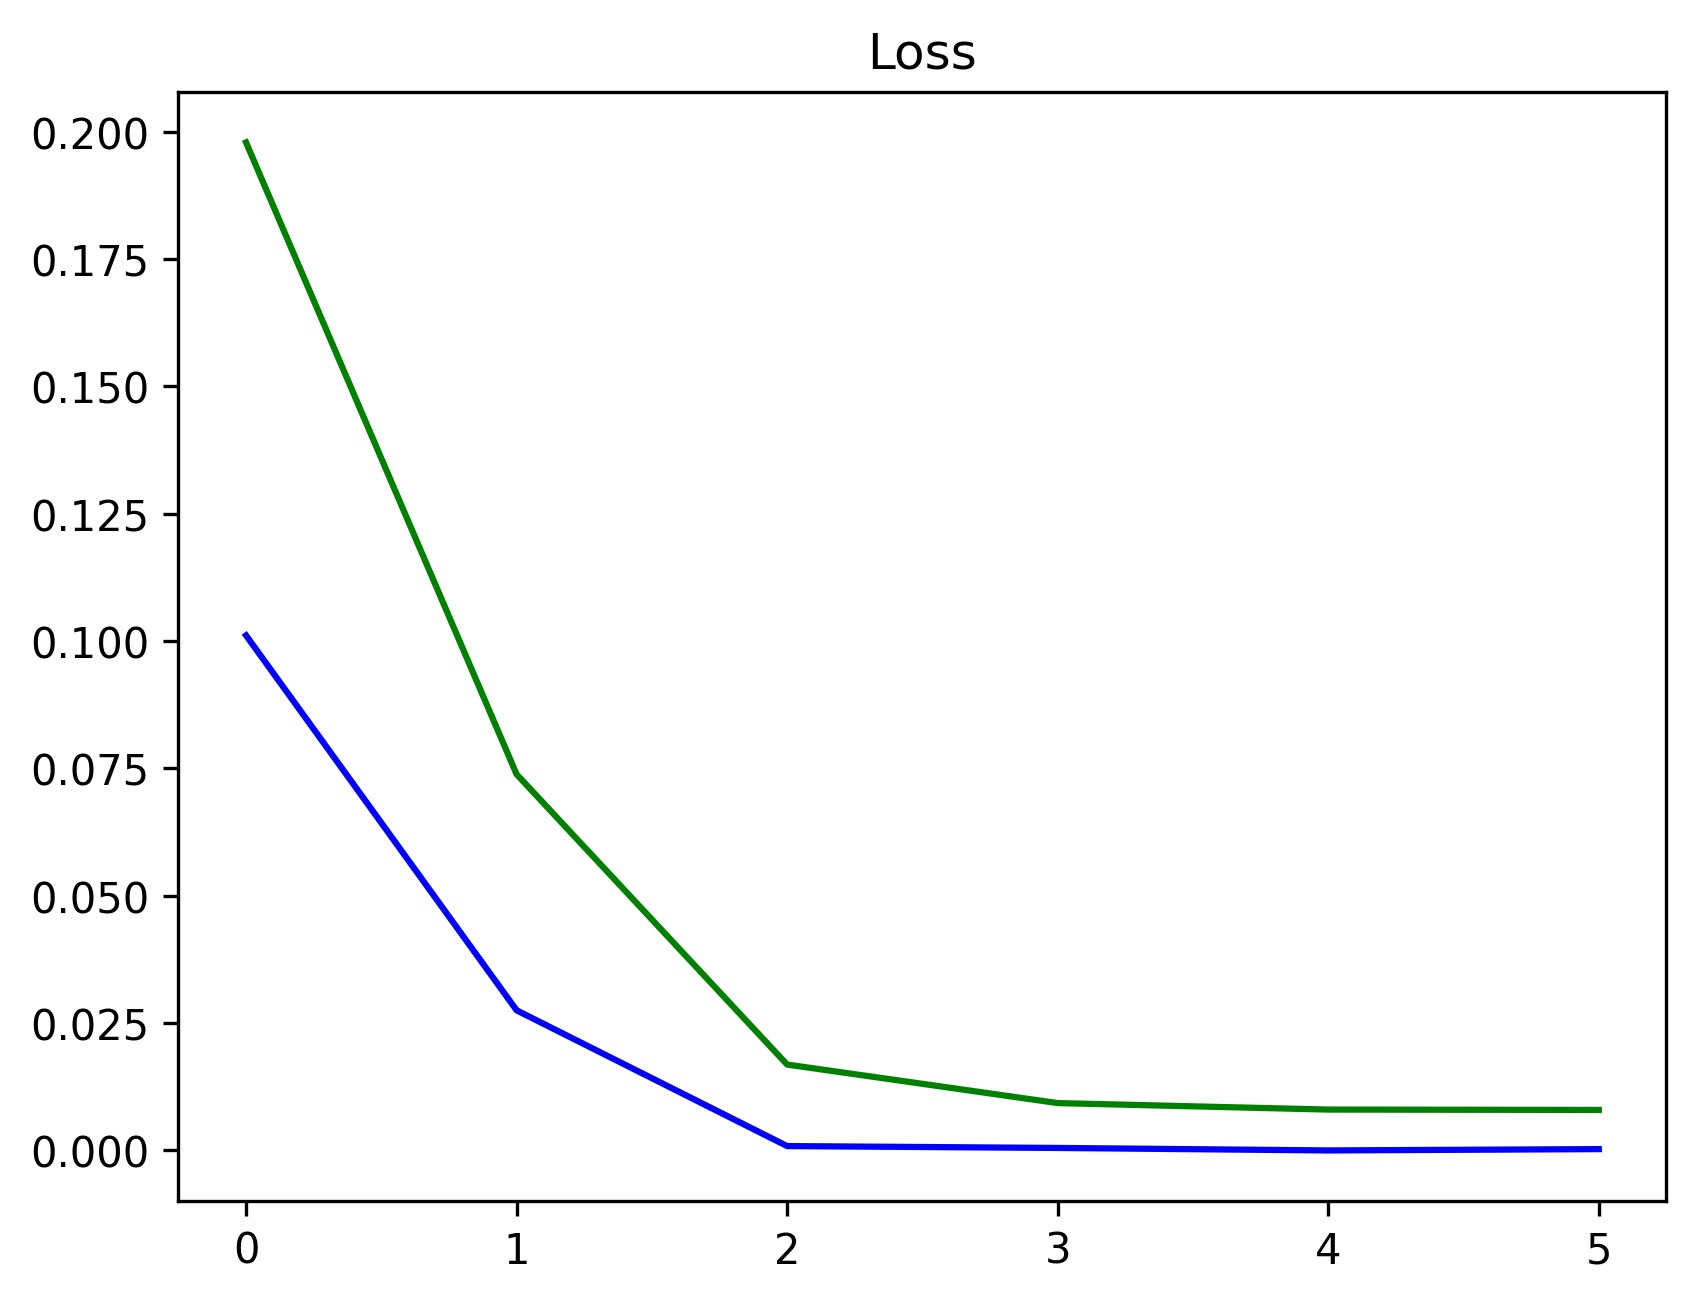

In [944]:
# print(history.history['val_loss'][-1])
# acc = history.history['accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
# plt.plot(epochs, acc)
plt.title('Training accuracy')
# plt.savefig('images/model_acc.png', bbox_inches='tight')
plt.plot(epochs, loss, c='green')
plt.plot(epochs, val_loss, 'blue')
plt.title('Loss')

plt.savefig('images/model_loss.png')

Predicting...
9/9 [==============================] - 1s 105ms/step
Reshaping predicted
Training duration:117796.10408520699


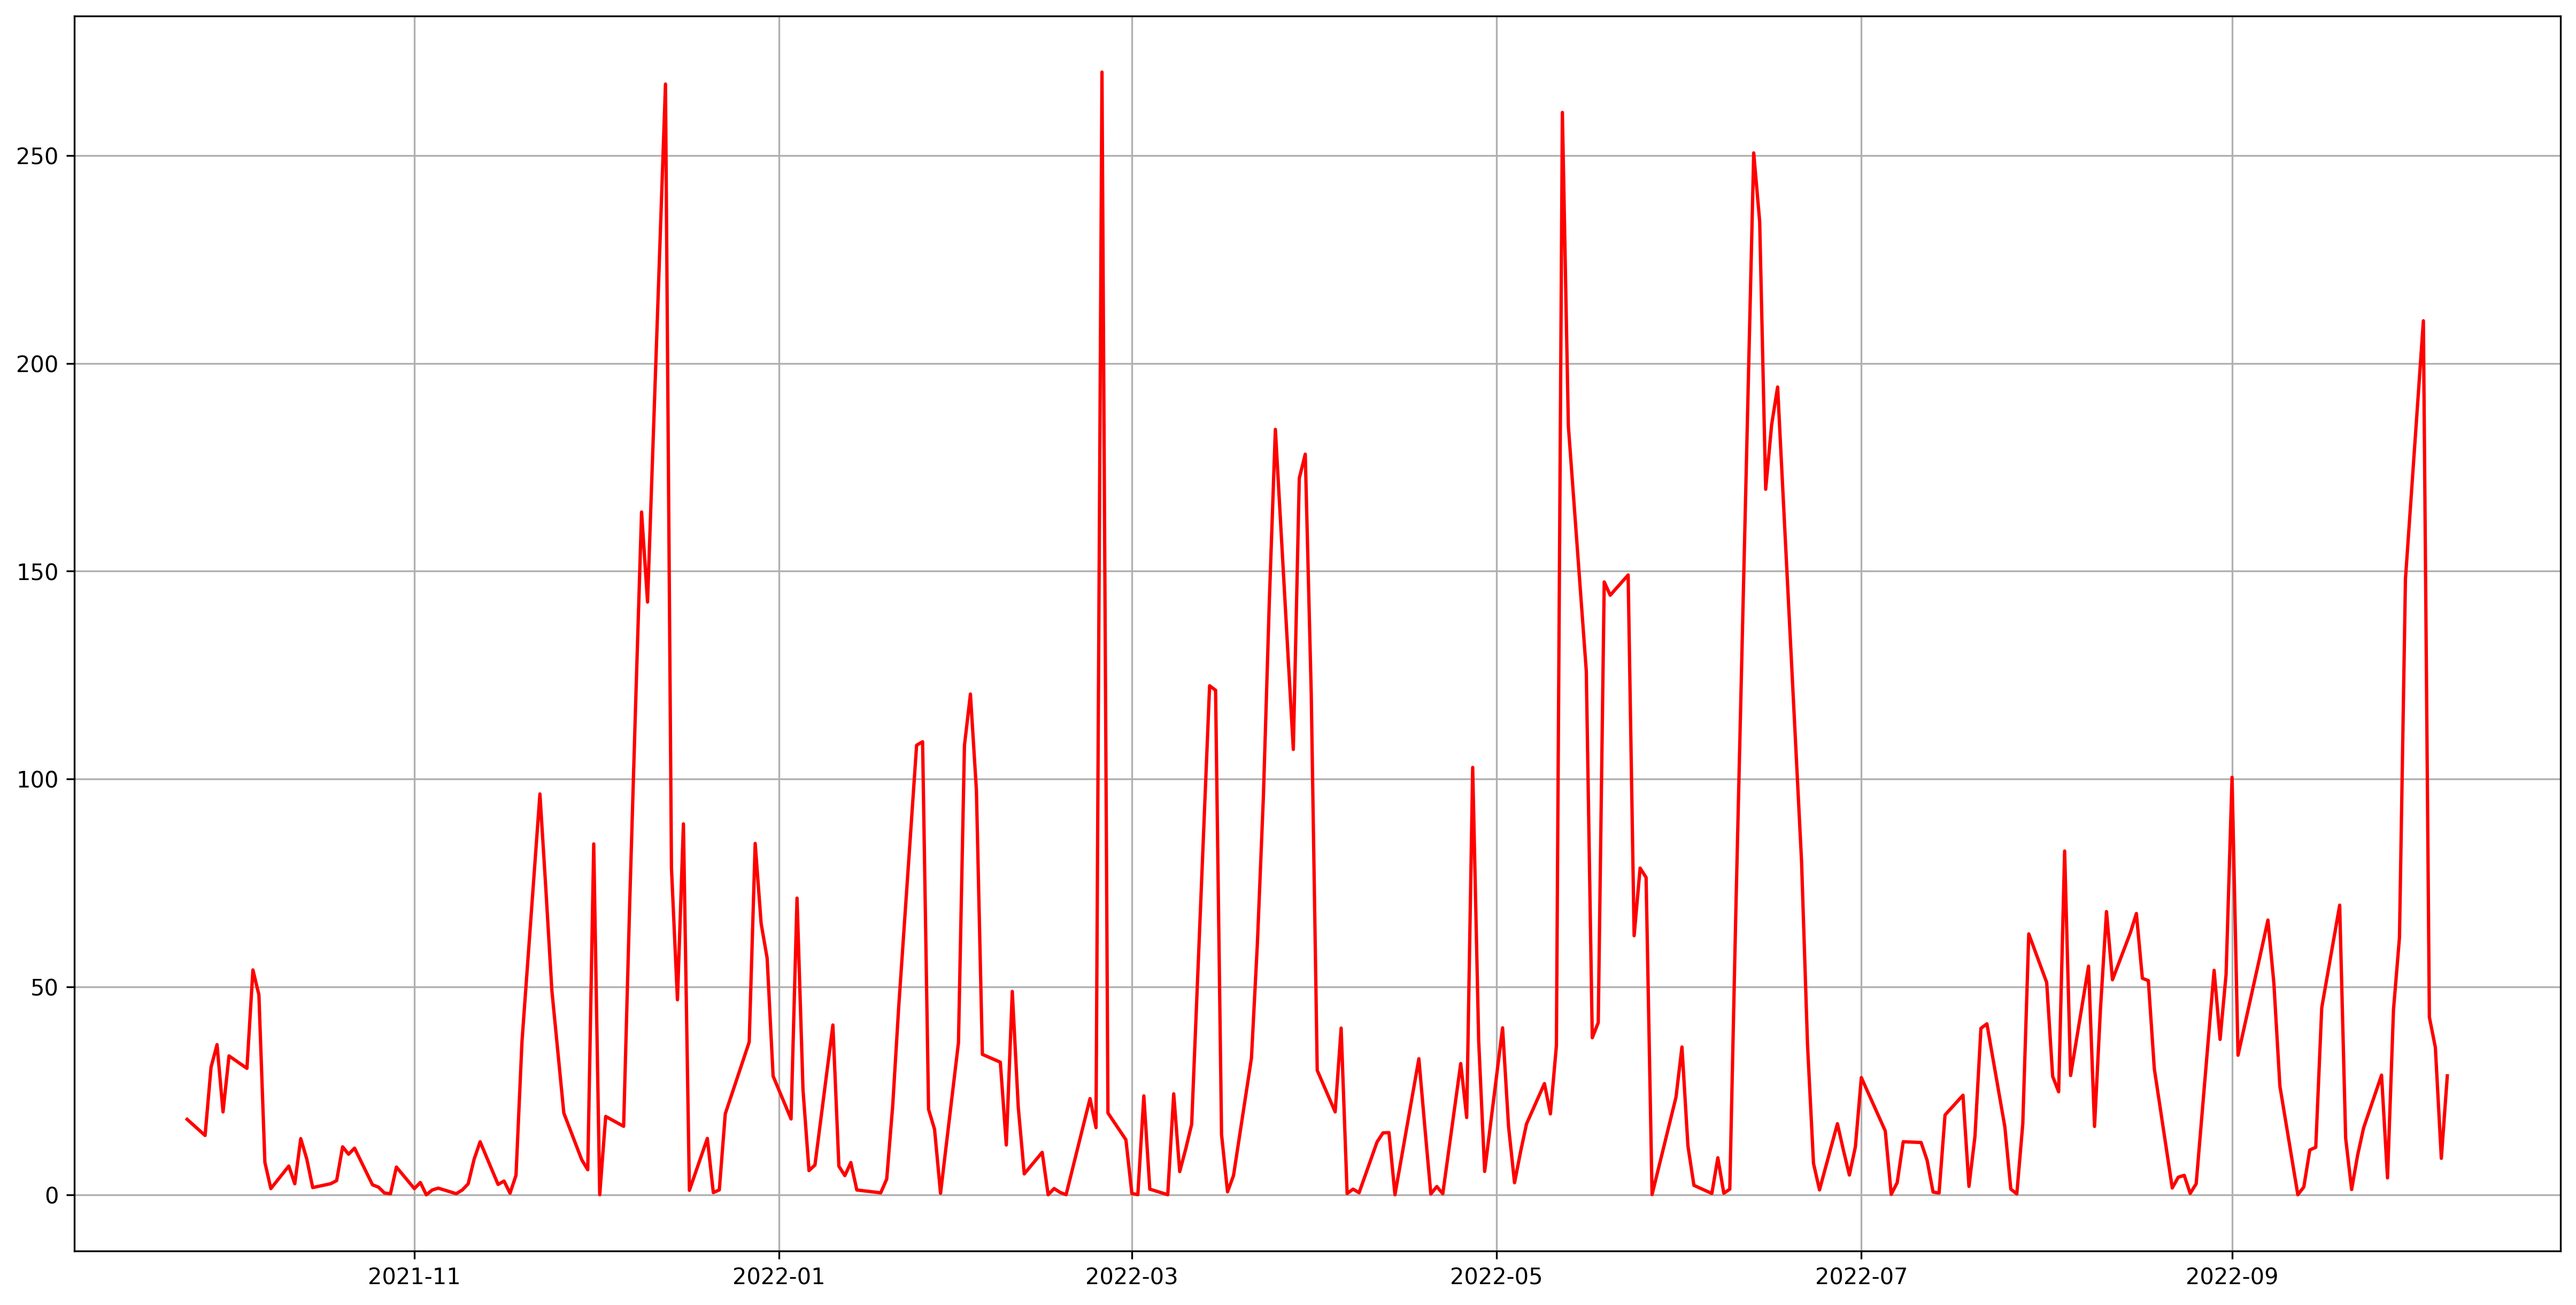

In [ ]:
# global_start_time = time.time()


print("Predicting...")
predicted = model.predict(X_test)

print("Reshaping predicted")

predicted = scaler.inverse_transform(predicted)
predicted = np.reshape(predicted, (predicted.size,))
# print(predicted)

train = df_data_general.loc[:500, 'Open']
train.index = df_data_general.loc[:500, 'Date']

valid = pd.DataFrame(df_data_general.loc[500:500 + len(predicted) - 1, 'Open'])
valid.index = df_data_general.loc[500:500 + len(predicted) - 1, 'Date']

valid['Predictions'] = predicted
plt.figure(figsize=(20, 10))
plt.grid()
# plt.plot(train, label='train')
# plt.plot(valid, label='prediction')

# plt.gca().legend(('Training','Actual', 'Prediction'))
# plt.savefig('images/prediction')

plt.plot(((valid['Open'] - predicted) ** 2), 'r', label='Root-mean- deviation')
plt.savefig('images/deviation')

# # plt.figure(figsize=(20, 8))
# # plt.plot(y_test[:len(y_test)], 'b', label='Observed')
# # plt.plot(predicted[:len(y_test)], 'g', label='Predicted')
# plt.plot(((y_test - predicted) ** 2), 'r', label='Root-mean-square deviation')
# # plt.legend()
# # plt.show()

print('Training duration:{}'.format(time.time() - global_start_time))

Predicting...
1/1 [==============================] - 0s 109ms/step
Training duration:94224.36834597588


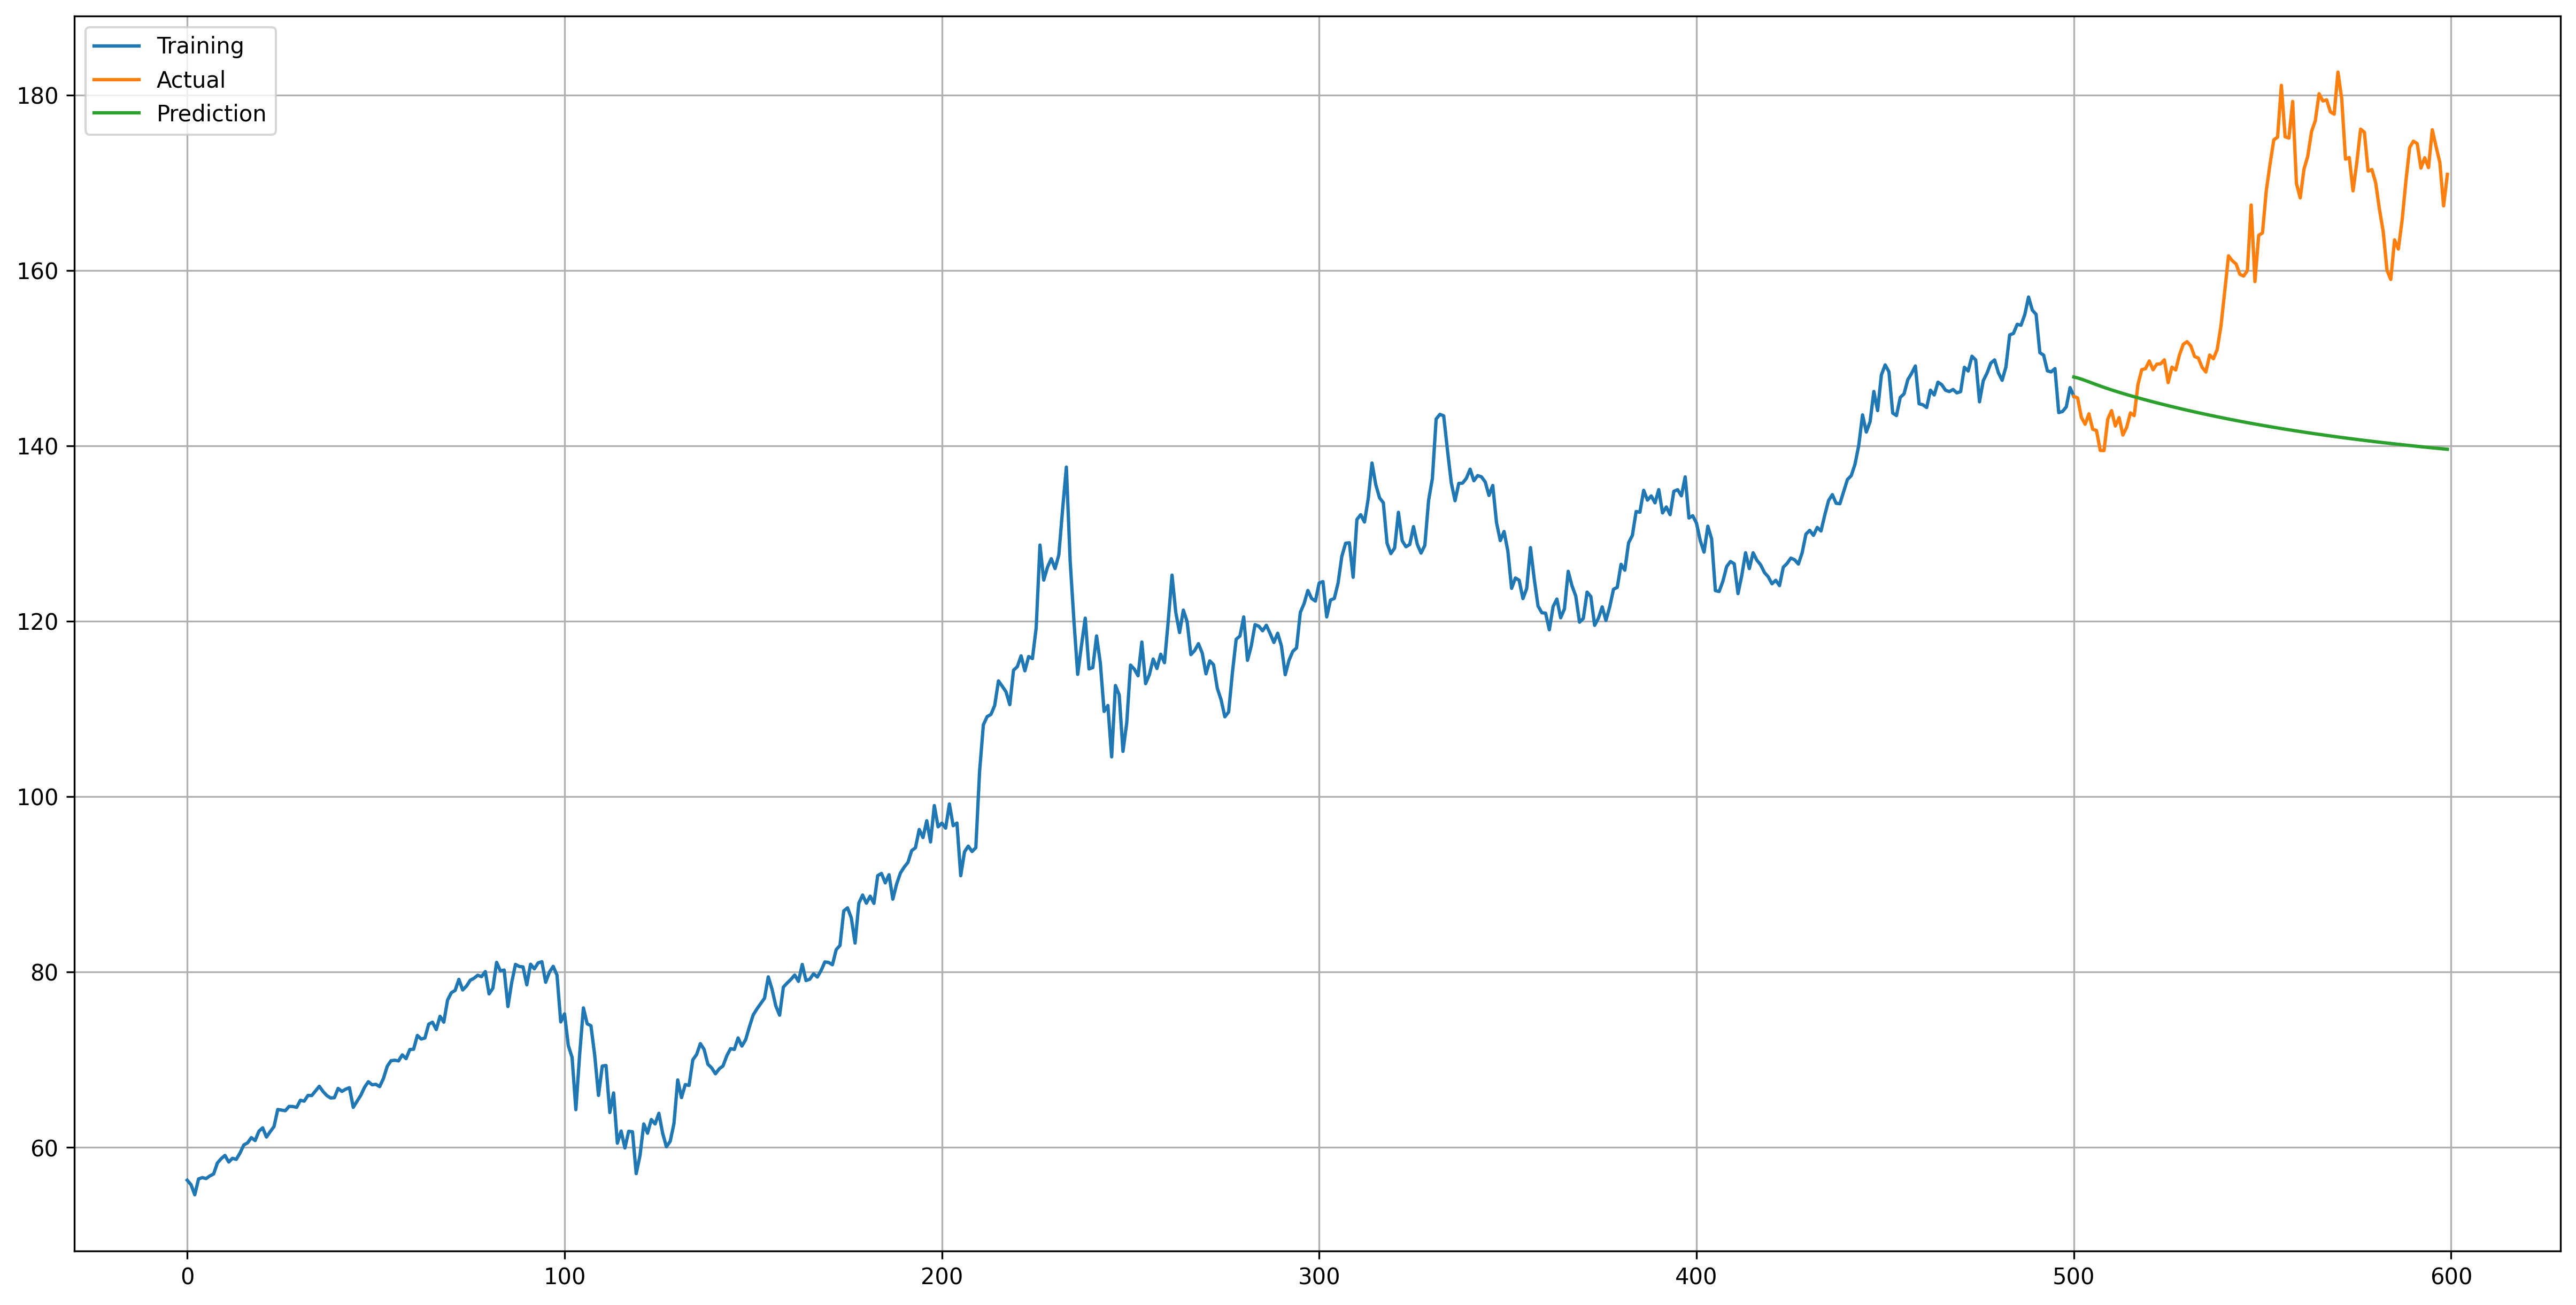

In [986]:
# global_start_time = time.time()
predict_num = 100
initial_data_for_predict = X_test[0:1]
predicted_values = []
for i in range(predict_num):
    predicted = model.predict(initial_data_for_predict)
    predicted_values.append(float(predicted[0]))
    initial_data_for_predict = initial_data_for_predict[:, 1:]
    initial_data_for_predict = np.append(initial_data_for_predict, predicted).reshape(1, 99)

predicted_values = np.array(predicted_values)
predicted = scaler.inverse_transform(np.array(predicted_values).reshape(len(predicted_values), 1))
predicted = np.reshape(predicted, (predicted.size,))

train = df_data_general.loc[:500, 'Open']
valid = pd.DataFrame(df_data_general.loc[500:500 + len(predicted) - 1, 'Open'])

valid['Predictions'] = predicted
plt.figure(figsize=(20, 10))
plt.grid()
plt.plot(train, label='train')
plt.plot(valid, label='prediction')

plt.gca().legend(('Training', 'Actual', 'Prediction'))
plt.savefig('images/prediction_me')

# # plt.figure(figsize=(20, 8))
# # plt.plot(y_test[:len(y_test)], 'b', label='Observed')
# # plt.plot(predicted[:len(y_test)], 'g', label='Predicted')
# # plt.plot(((y_test - predicted) ** 2), 'r', label='Root-mean-square deviation')
# # plt.legend()
# # plt.show()

print('Training duration:{}'.format(time.time() - global_start_time))

In [921]:
def objective(trial):
    params = {
        'validation_split': trial.suggest_float('validation_split', 0.001, 0.1),
        'epochs': trial.suggest_int('epochs', 3, 20),
        'batch_size': trial.suggest_int('batch_size', 20, 300),
        'dropout': trial.suggest_float('dropout', 0.0, 0.4),
        'units1': trial.suggest_int('units1', 1, 200),
        'units2': trial.suggest_int('units2', 1, 200),
        'units3': trial.suggest_int('units3', 1, 200),

    }

    model, history = build_model(
        validation_split=params['validation_split'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        dropout=params['dropout'],
        units1=params['units1'],
        units2=params['units2'],
        units3=params['units3']
    )
    return history.history['val_loss'][-1]


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)



[I 2022-10-11 11:00:18,017] A new study created in memory with name: no-name-412d1b8c-0884-4906-8d9a-cf5c776a4666


Epoch 1/16
3/3 [==============================] - 9s 855ms/step - loss: 0.2075 - accuracy: 0.0000e+00 - val_loss: 0.3397 - val_accuracy: 0.0000e+00
Epoch 2/16
3/3 [==============================] - 1s 186ms/step - loss: 0.1017 - accuracy: 0.0000e+00 - val_loss: 0.1181 - val_accuracy: 0.0000e+00
Epoch 3/16
3/3 [==============================] - 1s 181ms/step - loss: 0.0323 - accuracy: 0.0000e+00 - val_loss: 0.0483 - val_accuracy: 0.0000e+00
Epoch 4/16
3/3 [==============================] - 1s 183ms/step - loss: 0.0210 - accuracy: 0.0000e+00 - val_loss: 0.0430 - val_accuracy: 0.0000e+00
Epoch 5/16
3/3 [==============================] - 1s 183ms/step - loss: 0.0201 - accuracy: 0.0000e+00 - val_loss: 0.0375 - val_accuracy: 0.0000e+00
Epoch 6/16
3/3 [==============================] - 1s 177ms/step - loss: 0.0168 - accuracy: 0.0000e+00 - val_loss: 0.0132 - val_accuracy: 0.0000e+00
Epoch 7/16
3/3 [==============================] - 1s 179ms/step - loss: 0.0161 - accuracy: 0.0000e+00 - val_loss

[I 2022-10-11 11:00:37,656] Trial 0 finished with value: 0.00246066739782691 and parameters: {'validation_split': 0.08912457826658422, 'epochs': 16, 'batch_size': 159, 'dropout': 0.12799063554827864, 'units1': 50, 'units2': 2, 'units3': 29}. Best is trial 0 with value: 0.00246066739782691.


Epoch 1/20
3/3 [==============================] - 11s 2s/step - loss: 0.1218 - accuracy: 0.0000e+00 - val_loss: 0.1970 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 3s 1s/step - loss: 0.0355 - accuracy: 0.0000e+00 - val_loss: 0.0179 - val_accuracy: 0.0000e+00
Epoch 3/20
3/3 [==============================] - 2s 915ms/step - loss: 0.0079 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 3s 937ms/step - loss: 0.0069 - accuracy: 0.0000e+00 - val_loss: 0.0232 - val_accuracy: 0.0000e+00
Epoch 5/20
3/3 [==============================] - 3s 825ms/step - loss: 0.0136 - accuracy: 0.0000e+00 - val_loss: 0.0111 - val_accuracy: 0.0000e+00
Epoch 6/20
3/3 [==============================] - 3s 1s/step - loss: 0.0183 - accuracy: 0.0000e+00 - val_loss: 0.0229 - val_accuracy: 0.0000e+00
Epoch 7/20
3/3 [==============================] - 3s 1s/step - loss: 0.0078 - accuracy: 0.0000e+00 - val_loss: 0.0031 - 

[I 2022-10-11 11:01:30,933] Trial 1 finished with value: 0.04027821123600006 and parameters: {'validation_split': 0.03896172598203874, 'epochs': 20, 'batch_size': 138, 'dropout': 0.32895813977816235, 'units1': 62, 'units2': 111, 'units3': 177}. Best is trial 0 with value: 0.00246066739782691.


Epoch 1/11
11/11 [==============================] - 10s 337ms/step - loss: 0.0455 - accuracy: 0.0000e+00 - val_loss: 0.0059 - val_accuracy: 0.0000e+00
Epoch 2/11
11/11 [==============================] - 3s 230ms/step - loss: 0.0102 - accuracy: 0.0000e+00 - val_loss: 0.0039 - val_accuracy: 0.0000e+00
Epoch 3/11
11/11 [==============================] - 2s 223ms/step - loss: 0.0073 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 4/11
11/11 [==============================] - 2s 215ms/step - loss: 0.0106 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 5/11
11/11 [==============================] - 2s 203ms/step - loss: 0.0050 - accuracy: 0.0000e+00 - val_loss: 0.0334 - val_accuracy: 0.0000e+00
Epoch 6/11
11/11 [==============================] - 2s 202ms/step - loss: 0.0071 - accuracy: 0.0000e+00 - val_loss: 0.0217 - val_accuracy: 0.0000e+00
Epoch 7/11
11/11 [==============================] - 2s 211ms/step - loss: 0.0086 - accuracy: 0.0000

[I 2022-10-11 11:02:04,567] Trial 2 finished with value: 0.011476855725049973 and parameters: {'validation_split': 0.018215032657788295, 'epochs': 11, 'batch_size': 36, 'dropout': 0.2299958970312627, 'units1': 68, 'units2': 54, 'units3': 178}. Best is trial 0 with value: 0.00246066739782691.


Epoch 1/16
2/2 [==============================] - 9s 2s/step - loss: 0.1359 - accuracy: 0.0000e+00 - val_loss: 0.1069 - val_accuracy: 0.0000e+00
Epoch 2/16
2/2 [==============================] - 2s 1s/step - loss: 0.0496 - accuracy: 0.0000e+00 - val_loss: 0.1730 - val_accuracy: 0.0000e+00
Epoch 3/16
2/2 [==============================] - 2s 993ms/step - loss: 0.0402 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 4/16
2/2 [==============================] - 2s 978ms/step - loss: 0.0037 - accuracy: 0.0000e+00 - val_loss: 0.0038 - val_accuracy: 0.0000e+00
Epoch 5/16
2/2 [==============================] - 2s 926ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 6/16
2/2 [==============================] - 2s 982ms/step - loss: 0.0028 - accuracy: 0.0000e+00 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 7/16
2/2 [==============================] - 2s 944ms/step - loss: 0.0023 - accuracy: 0.0000e+00 - val_loss: 0.00

[I 2022-10-11 11:02:42,033] Trial 3 finished with value: 0.016937024891376495 and parameters: {'validation_split': 0.08001925701322321, 'epochs': 16, 'batch_size': 188, 'dropout': 0.0018677284091523916, 'units1': 152, 'units2': 148, 'units3': 80}. Best is trial 0 with value: 0.00246066739782691.


Epoch 1/18
3/3 [==============================] - 13s 3s/step - loss: 0.1132 - accuracy: 0.0000e+00 - val_loss: 6.8994e-04 - val_accuracy: 0.0000e+00
Epoch 2/18
3/3 [==============================] - 5s 1s/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 3/18
3/3 [==============================] - 2s 721ms/step - loss: 0.0035 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 4/18
3/3 [==============================] - 2s 708ms/step - loss: 0.0035 - accuracy: 0.0000e+00 - val_loss: 0.0138 - val_accuracy: 0.0000e+00
Epoch 5/18
3/3 [==============================] - 3s 848ms/step - loss: 0.0173 - accuracy: 0.0000e+00 - val_loss: 0.0168 - val_accuracy: 0.0000e+00
Epoch 6/18
3/3 [==============================] - 2s 747ms/step - loss: 0.0088 - accuracy: 0.0000e+00 - val_loss: 0.0045 - val_accuracy: 0.0000e+00
Epoch 7/18
3/3 [==============================] - 2s 710ms/step - loss: 0.0042 - accuracy: 0.0000e+00 - val_loss:

[I 2022-10-11 11:03:38,528] Trial 4 finished with value: 0.0034267897717654705 and parameters: {'validation_split': 0.01884367463295178, 'epochs': 18, 'batch_size': 151, 'dropout': 0.016688106657858182, 'units1': 186, 'units2': 140, 'units3': 57}. Best is trial 0 with value: 0.00246066739782691.


Epoch 1/11
2/2 [==============================] - 9s 2s/step - loss: 0.1773 - accuracy: 0.0000e+00 - val_loss: 0.1149 - val_accuracy: 0.0000e+00
Epoch 2/11
2/2 [==============================] - 2s 707ms/step - loss: 0.0936 - accuracy: 0.0000e+00 - val_loss: 0.0743 - val_accuracy: 0.0000e+00
Epoch 3/11
2/2 [==============================] - 2s 711ms/step - loss: 0.0203 - accuracy: 0.0000e+00 - val_loss: 0.0061 - val_accuracy: 0.0000e+00
Epoch 4/11
2/2 [==============================] - 2s 701ms/step - loss: 0.0095 - accuracy: 0.0000e+00 - val_loss: 0.0065 - val_accuracy: 0.0000e+00
Epoch 5/11
2/2 [==============================] - 2s 728ms/step - loss: 0.0090 - accuracy: 0.0000e+00 - val_loss: 0.0054 - val_accuracy: 0.0000e+00
Epoch 6/11
2/2 [==============================] - 2s 691ms/step - loss: 0.0085 - accuracy: 0.0000e+00 - val_loss: 0.0037 - val_accuracy: 0.0000e+00
Epoch 7/11
2/2 [==============================] - 2s 718ms/step - loss: 0.0071 - accuracy: 0.0000e+00 - val_loss: 0

[I 2022-10-11 11:04:05,202] Trial 5 finished with value: 0.0019063567742705345 and parameters: {'validation_split': 0.05890144821361693, 'epochs': 11, 'batch_size': 225, 'dropout': 0.3144968957928363, 'units1': 199, 'units2': 47, 'units3': 98}. Best is trial 5 with value: 0.0019063567742705345.


Epoch 1/18
3/3 [==============================] - 9s 1s/step - loss: 0.1340 - accuracy: 0.0000e+00 - val_loss: 0.0288 - val_accuracy: 0.0000e+00
Epoch 2/18
3/3 [==============================] - 2s 573ms/step - loss: 0.0149 - accuracy: 0.0000e+00 - val_loss: 0.0133 - val_accuracy: 0.0000e+00
Epoch 3/18
3/3 [==============================] - 2s 540ms/step - loss: 0.0133 - accuracy: 0.0000e+00 - val_loss: 9.2755e-04 - val_accuracy: 0.0000e+00
Epoch 4/18
3/3 [==============================] - 2s 566ms/step - loss: 0.0124 - accuracy: 0.0000e+00 - val_loss: 8.2498e-04 - val_accuracy: 0.0000e+00
Epoch 5/18
3/3 [==============================] - 2s 540ms/step - loss: 0.0116 - accuracy: 0.0000e+00 - val_loss: 0.0165 - val_accuracy: 0.0000e+00
Epoch 6/18
3/3 [==============================] - 2s 540ms/step - loss: 0.0143 - accuracy: 0.0000e+00 - val_loss: 0.0074 - val_accuracy: 0.0000e+00
Epoch 7/18
3/3 [==============================] - 2s 546ms/step - loss: 0.0189 - accuracy: 0.0000e+00 - val

[I 2022-10-11 11:04:48,805] Trial 6 finished with value: 0.049042847007513046 and parameters: {'validation_split': 0.056350967906154, 'epochs': 18, 'batch_size': 171, 'dropout': 0.35213081211600966, 'units1': 192, 'units2': 117, 'units3': 33}. Best is trial 5 with value: 0.0019063567742705345.


Epoch 1/12
6/6 [==============================] - 10s 703ms/step - loss: 0.0809 - accuracy: 0.0000e+00 - val_loss: 0.0053 - val_accuracy: 0.0000e+00
Epoch 2/12
6/6 [==============================] - 4s 756ms/step - loss: 0.0057 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 3/12
6/6 [==============================] - 4s 784ms/step - loss: 0.0050 - accuracy: 0.0000e+00 - val_loss: 0.0061 - val_accuracy: 0.0000e+00
Epoch 4/12
6/6 [==============================] - 4s 672ms/step - loss: 0.0168 - accuracy: 0.0000e+00 - val_loss: 0.0090 - val_accuracy: 0.0000e+00
Epoch 5/12
6/6 [==============================] - 4s 682ms/step - loss: 0.0096 - accuracy: 0.0000e+00 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 6/12
6/6 [==============================] - 3s 481ms/step - loss: 0.0046 - accuracy: 0.0000e+00 - val_loss: 0.0100 - val_accuracy: 0.0000e+00
Epoch 7/12
6/6 [==============================] - 4s 698ms/step - loss: 0.0104 - accuracy: 0.0000e+00 - val_los

[I 2022-10-11 11:05:41,099] Trial 7 finished with value: 0.013172167353332043 and parameters: {'validation_split': 0.06155501744551134, 'epochs': 12, 'batch_size': 64, 'dropout': 0.18362995457912984, 'units1': 199, 'units2': 148, 'units3': 57}. Best is trial 5 with value: 0.0019063567742705345.


Epoch 1/15
4/4 [==============================] - 20s 1s/step - loss: 0.1199 - accuracy: 0.0000e+00 - val_loss: 0.0373 - val_accuracy: 0.0000e+00
Epoch 2/15
4/4 [==============================] - 2s 532ms/step - loss: 0.0103 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 3/15
4/4 [==============================] - 2s 529ms/step - loss: 0.0050 - accuracy: 0.0000e+00 - val_loss: 5.4740e-04 - val_accuracy: 0.0000e+00
Epoch 4/15
4/4 [==============================] - 2s 543ms/step - loss: 0.0042 - accuracy: 0.0000e+00 - val_loss: 1.7238e-04 - val_accuracy: 0.0000e+00
Epoch 5/15
4/4 [==============================] - 2s 476ms/step - loss: 0.0037 - accuracy: 0.0000e+00 - val_loss: 0.0058 - val_accuracy: 0.0000e+00
Epoch 6/15
4/4 [==============================] - 2s 543ms/step - loss: 0.0163 - accuracy: 0.0000e+00 - val_loss: 8.4939e-04 - val_accuracy: 0.0000e+00
Epoch 7/15
4/4 [==============================] - 2s 513ms/step - loss: 0.0036 - accuracy: 0.0000e+00 

[I 2022-10-11 11:06:32,303] Trial 8 finished with value: 0.006327164359390736 and parameters: {'validation_split': 0.012394021515972208, 'epochs': 15, 'batch_size': 109, 'dropout': 0.19960837363590064, 'units1': 22, 'units2': 104, 'units3': 196}. Best is trial 5 with value: 0.0019063567742705345.


Epoch 1/17
2/2 [==============================] - 9s 2s/step - loss: 0.1564 - accuracy: 0.0000e+00 - val_loss: 0.0871 - val_accuracy: 0.0000e+00
Epoch 2/17
2/2 [==============================] - 2s 688ms/step - loss: 0.0660 - accuracy: 0.0000e+00 - val_loss: 0.0361 - val_accuracy: 0.0000e+00
Epoch 3/17
2/2 [==============================] - 1s 611ms/step - loss: 0.0115 - accuracy: 0.0000e+00 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 4/17
2/2 [==============================] - 1s 651ms/step - loss: 0.0054 - accuracy: 0.0000e+00 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 5/17
2/2 [==============================] - 1s 631ms/step - loss: 0.0048 - accuracy: 0.0000e+00 - val_loss: 0.0015 - val_accuracy: 0.0000e+00
Epoch 6/17
2/2 [==============================] - 1s 625ms/step - loss: 0.0044 - accuracy: 0.0000e+00 - val_loss: 7.6765e-04 - val_accuracy: 0.0000e+00
Epoch 7/17
2/2 [==============================] - 1s 699ms/step - loss: 0.0039 - accuracy: 0.0000e+00 - val_los

[I 2022-10-11 11:07:04,885] Trial 9 finished with value: 0.01005131471902132 and parameters: {'validation_split': 0.02403062793137905, 'epochs': 17, 'batch_size': 223, 'dropout': 0.03113661463025026, 'units1': 73, 'units2': 31, 'units3': 192}. Best is trial 5 with value: 0.0019063567742705345.


Epoch 1/3
2/2 [==============================] - 11s 2s/step - loss: 0.1836 - accuracy: 0.0000e+00 - val_loss: 0.3225 - val_accuracy: 0.0000e+00
Epoch 2/3
2/2 [==============================] - 3s 733ms/step - loss: 0.1155 - accuracy: 0.0000e+00 - val_loss: 0.0034 - val_accuracy: 0.0000e+00
Epoch 3/3
2/2 [==============================] - 3s 919ms/step - loss: 0.0064 - accuracy: 0.0000e+00 - val_loss: 0.0074 - val_accuracy: 0.0000e+00


[I 2022-10-11 11:07:22,360] Trial 10 finished with value: 0.007383531890809536 and parameters: {'validation_split': 0.07265539307600298, 'epochs': 3, 'batch_size': 294, 'dropout': 0.29635656019396406, 'units1': 127, 'units2': 200, 'units3': 132}. Best is trial 5 with value: 0.0019063567742705345.


Epoch 1/8
2/2 [==============================] - 9s 2s/step - loss: 0.2549 - accuracy: 0.0000e+00 - val_loss: 0.4952 - val_accuracy: 0.0000e+00
Epoch 2/8
2/2 [==============================] - 0s 173ms/step - loss: 0.1936 - accuracy: 0.0000e+00 - val_loss: 0.4296 - val_accuracy: 0.0000e+00
Epoch 3/8
2/2 [==============================] - 0s 180ms/step - loss: 0.1625 - accuracy: 0.0000e+00 - val_loss: 0.3788 - val_accuracy: 0.0000e+00
Epoch 4/8
2/2 [==============================] - 0s 165ms/step - loss: 0.1378 - accuracy: 0.0000e+00 - val_loss: 0.3363 - val_accuracy: 0.0000e+00
Epoch 5/8
2/2 [==============================] - 0s 167ms/step - loss: 0.1190 - accuracy: 0.0000e+00 - val_loss: 0.2988 - val_accuracy: 0.0000e+00
Epoch 6/8
2/2 [==============================] - 0s 218ms/step - loss: 0.1020 - accuracy: 0.0000e+00 - val_loss: 0.2662 - val_accuracy: 0.0000e+00
Epoch 7/8
2/2 [==============================] - 0s 159ms/step - loss: 0.0886 - accuracy: 0.0000e+00 - val_loss: 0.2380 -

[I 2022-10-11 11:07:34,126] Trial 11 finished with value: 0.21130089461803436 and parameters: {'validation_split': 0.09389343161260245, 'epochs': 8, 'batch_size': 246, 'dropout': 0.1155684759098804, 'units1': 8, 'units2': 3, 'units3': 6}. Best is trial 5 with value: 0.0019063567742705345.


Epoch 1/12
2/2 [==============================] - 9s 2s/step - loss: 0.1572 - accuracy: 0.0000e+00 - val_loss: 0.0073 - val_accuracy: 0.0000e+00
Epoch 2/12
2/2 [==============================] - 1s 648ms/step - loss: 0.0334 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 3/12
2/2 [==============================] - 1s 617ms/step - loss: 0.0114 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 4/12
2/2 [==============================] - 1s 609ms/step - loss: 0.0096 - accuracy: 0.0000e+00 - val_loss: 8.8528e-04 - val_accuracy: 0.0000e+00
Epoch 5/12
2/2 [==============================] - 1s 653ms/step - loss: 0.0116 - accuracy: 0.0000e+00 - val_loss: 0.0114 - val_accuracy: 0.0000e+00
Epoch 6/12
2/2 [==============================] - 1s 576ms/step - loss: 0.0251 - accuracy: 0.0000e+00 - val_loss: 0.0037 - val_accuracy: 0.0000e+00
Epoch 7/12
2/2 [==============================] - 1s 627ms/step - loss: 0.0161 - accuracy: 0.0000e+00 - val_los

[I 2022-10-11 11:08:00,494] Trial 12 finished with value: 0.0006105400971136987 and parameters: {'validation_split': 0.09744229546064193, 'epochs': 12, 'batch_size': 226, 'dropout': 0.39720717347120044, 'units1': 111, 'units2': 62, 'units3': 118}. Best is trial 12 with value: 0.0006105400971136987.


Epoch 1/9
2/2 [==============================] - 12s 2s/step - loss: 0.1968 - accuracy: 0.0000e+00 - val_loss: 0.0212 - val_accuracy: 0.0000e+00
Epoch 2/9
2/2 [==============================] - 2s 539ms/step - loss: 0.0391 - accuracy: 0.0000e+00 - val_loss: 0.0117 - val_accuracy: 0.0000e+00
Epoch 3/9
2/2 [==============================] - 1s 547ms/step - loss: 0.0111 - accuracy: 0.0000e+00 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 4/9
2/2 [==============================] - 1s 553ms/step - loss: 0.0108 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 5/9
2/2 [==============================] - 1s 537ms/step - loss: 0.0131 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 6/9
2/2 [==============================] - 1s 554ms/step - loss: 0.0163 - accuracy: 0.0000e+00 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 7/9
2/2 [==============================] - 2s 743ms/step - loss: 0.0129 - accuracy: 0.0000e+00 - val_loss: 0.0014 

[I 2022-10-11 11:08:27,024] Trial 13 finished with value: 0.0014846099074929953 and parameters: {'validation_split': 0.03993613795036848, 'epochs': 9, 'batch_size': 256, 'dropout': 0.39506099035906206, 'units1': 118, 'units2': 63, 'units3': 131}. Best is trial 12 with value: 0.0006105400971136987.


Epoch 1/7
2/2 [==============================] - 11s 2s/step - loss: 0.2330 - accuracy: 0.0000e+00 - val_loss: 0.0766 - val_accuracy: 0.0000e+00
Epoch 2/7
2/2 [==============================] - 2s 635ms/step - loss: 0.0721 - accuracy: 0.0000e+00 - val_loss: 0.0521 - val_accuracy: 0.0000e+00
Epoch 3/7
2/2 [==============================] - 2s 533ms/step - loss: 0.0183 - accuracy: 0.0000e+00 - val_loss: 0.0114 - val_accuracy: 0.0000e+00
Epoch 4/7
2/2 [==============================] - 2s 556ms/step - loss: 0.0097 - accuracy: 0.0000e+00 - val_loss: 0.0055 - val_accuracy: 0.0000e+00
Epoch 5/7
2/2 [==============================] - 2s 595ms/step - loss: 0.0087 - accuracy: 0.0000e+00 - val_loss: 0.0041 - val_accuracy: 0.0000e+00
Epoch 6/7
2/2 [==============================] - 2s 563ms/step - loss: 0.0069 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 7/7
2/2 [==============================] - 2s 560ms/step - loss: 0.0068 - accuracy: 0.0000e+00 - val_loss: 0.0012 

[I 2022-10-11 11:08:49,966] Trial 14 finished with value: 0.0012060041772201657 and parameters: {'validation_split': 0.03821502894971615, 'epochs': 7, 'batch_size': 300, 'dropout': 0.3992539834560818, 'units1': 110, 'units2': 79, 'units3': 146}. Best is trial 12 with value: 0.0006105400971136987.


Epoch 1/5
2/2 [==============================] - 10s 2s/step - loss: 0.1465 - accuracy: 0.0000e+00 - val_loss: 0.0592 - val_accuracy: 0.0000e+00
Epoch 2/5
2/2 [==============================] - 2s 953ms/step - loss: 0.0390 - accuracy: 0.0000e+00 - val_loss: 0.0956 - val_accuracy: 0.0000e+00
Epoch 3/5
2/2 [==============================] - 3s 915ms/step - loss: 0.0418 - accuracy: 0.0000e+00 - val_loss: 6.5522e-04 - val_accuracy: 0.0000e+00
Epoch 4/5
2/2 [==============================] - 3s 675ms/step - loss: 0.0090 - accuracy: 0.0000e+00 - val_loss: 1.3994e-04 - val_accuracy: 0.0000e+00
Epoch 5/5
2/2 [==============================] - 2s 523ms/step - loss: 0.0080 - accuracy: 0.0000e+00 - val_loss: 1.2471e-05 - val_accuracy: 0.0000e+00


[I 2022-10-11 11:09:10,952] Trial 15 finished with value: 1.2470760339056142e-05 and parameters: {'validation_split': 0.001570309257281112, 'epochs': 5, 'batch_size': 299, 'dropout': 0.39389618853447506, 'units1': 100, 'units2': 77, 'units3': 137}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/3
2/2 [==============================] - 12s 2s/step - loss: 0.1946 - accuracy: 0.0000e+00 - val_loss: 0.1405 - val_accuracy: 0.0000e+00
Epoch 2/3
2/2 [==============================] - 2s 881ms/step - loss: 0.0920 - accuracy: 0.0000e+00 - val_loss: 0.0351 - val_accuracy: 0.0000e+00
Epoch 3/3
2/2 [==============================] - 2s 760ms/step - loss: 0.0167 - accuracy: 0.0000e+00 - val_loss: 6.9140e-04 - val_accuracy: 0.0000e+00


[I 2022-10-11 11:09:28,599] Trial 16 finished with value: 0.0006914022960700095 and parameters: {'validation_split': 0.002245571012830554, 'epochs': 3, 'batch_size': 269, 'dropout': 0.25988653733979805, 'units1': 150, 'units2': 87, 'units3': 114}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/6
2/2 [==============================] - 28s 4s/step - loss: 0.1602 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 2/6
2/2 [==============================] - 2s 875ms/step - loss: 0.0333 - accuracy: 0.0000e+00 - val_loss: 0.0092 - val_accuracy: 0.0000e+00
Epoch 3/6
2/2 [==============================] - 2s 939ms/step - loss: 0.0115 - accuracy: 0.0000e+00 - val_loss: 0.0066 - val_accuracy: 0.0000e+00
Epoch 4/6
2/2 [==============================] - 2s 1s/step - loss: 0.0104 - accuracy: 0.0000e+00 - val_loss: 0.0043 - val_accuracy: 0.0000e+00
Epoch 5/6
2/2 [==============================] - 1s 607ms/step - loss: 0.0112 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 6/6
2/2 [==============================] - 3s 1s/step - loss: 0.0182 - accuracy: 0.0000e+00 - val_loss: 0.0018 - val_accuracy: 0.0000e+00


[I 2022-10-11 11:10:07,474] Trial 17 finished with value: 0.00183482829015702 and parameters: {'validation_split': 0.07145502638857018, 'epochs': 6, 'batch_size': 213, 'dropout': 0.3581812849113767, 'units1': 88, 'units2': 29, 'units3': 154}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/14
2/2 [==============================] - 16s 3s/step - loss: 0.2057 - accuracy: 0.0000e+00 - val_loss: 0.0404 - val_accuracy: 0.0000e+00
Epoch 2/14
2/2 [==============================] - 2s 704ms/step - loss: 0.0512 - accuracy: 0.0000e+00 - val_loss: 0.0269 - val_accuracy: 0.0000e+00
Epoch 3/14
2/2 [==============================] - 2s 521ms/step - loss: 0.0123 - accuracy: 0.0000e+00 - val_loss: 0.0097 - val_accuracy: 0.0000e+00
Epoch 4/14
2/2 [==============================] - 1s 467ms/step - loss: 0.0074 - accuracy: 0.0000e+00 - val_loss: 0.0125 - val_accuracy: 0.0000e+00
Epoch 5/14
2/2 [==============================] - 1s 481ms/step - loss: 0.0077 - accuracy: 0.0000e+00 - val_loss: 0.0091 - val_accuracy: 0.0000e+00
Epoch 6/14
2/2 [==============================] - 2s 506ms/step - loss: 0.0069 - accuracy: 0.0000e+00 - val_loss: 0.0099 - val_accuracy: 0.0000e+00
Epoch 7/14
2/2 [==============================] - 1s 477ms/step - loss: 0.0070 - accuracy: 0.0000e+00 - val_loss: 

[I 2022-10-11 11:10:54,871] Trial 18 finished with value: 0.03934192657470703 and parameters: {'validation_split': 0.09917925096491352, 'epochs': 14, 'batch_size': 277, 'dropout': 0.27337389672769374, 'units1': 138, 'units2': 81, 'units3': 98}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/13
3/3 [==============================] - 12s 1s/step - loss: 0.1492 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 2/13
3/3 [==============================] - 3s 752ms/step - loss: 0.0084 - accuracy: 0.0000e+00 - val_loss: 0.0614 - val_accuracy: 0.0000e+00
Epoch 3/13
3/3 [==============================] - 2s 637ms/step - loss: 0.0435 - accuracy: 0.0000e+00 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 4/13
3/3 [==============================] - 3s 754ms/step - loss: 0.0072 - accuracy: 0.0000e+00 - val_loss: 0.0085 - val_accuracy: 0.0000e+00
Epoch 5/13
3/3 [==============================] - 4s 1s/step - loss: 0.0088 - accuracy: 0.0000e+00 - val_loss: 6.8060e-04 - val_accuracy: 0.0000e+00
Epoch 6/13
3/3 [==============================] - 3s 723ms/step - loss: 0.0061 - accuracy: 0.0000e+00 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 7/13
3/3 [==============================] - 4s 1s/step - loss: 0.0072 - accuracy: 0.0000e+00 - val_loss: 3.

[I 2022-10-11 11:11:45,293] Trial 19 finished with value: 0.002315811812877655 and parameters: {'validation_split': 0.0010531052344171163, 'epochs': 13, 'batch_size': 198, 'dropout': 0.35728312142708263, 'units1': 102, 'units2': 194, 'units3': 120}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/5
2/2 [==============================] - 12s 2s/step - loss: 0.1603 - accuracy: 0.0000e+00 - val_loss: 0.1489 - val_accuracy: 0.0000e+00
Epoch 2/5
2/2 [==============================] - 2s 825ms/step - loss: 0.0406 - accuracy: 0.0000e+00 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 3/5
2/2 [==============================] - 2s 760ms/step - loss: 0.0044 - accuracy: 0.0000e+00 - val_loss: 0.0062 - val_accuracy: 0.0000e+00
Epoch 4/5
2/2 [==============================] - 2s 739ms/step - loss: 0.0047 - accuracy: 0.0000e+00 - val_loss: 0.0152 - val_accuracy: 0.0000e+00
Epoch 5/5
2/2 [==============================] - 2s 758ms/step - loss: 0.0083 - accuracy: 0.0000e+00 - val_loss: 0.0436 - val_accuracy: 0.0000e+00


[I 2022-10-11 11:12:05,333] Trial 20 finished with value: 0.04358087480068207 and parameters: {'validation_split': 0.03033376168361069, 'epochs': 5, 'batch_size': 241, 'dropout': 0.15493785730359722, 'units1': 39, 'units2': 127, 'units3': 159}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/3
2/2 [==============================] - 11s 2s/step - loss: 0.1776 - accuracy: 0.0000e+00 - val_loss: 0.0780 - val_accuracy: 0.0000e+00
Epoch 2/3
2/2 [==============================] - 2s 927ms/step - loss: 0.0664 - accuracy: 0.0000e+00 - val_loss: 0.0203 - val_accuracy: 0.0000e+00
Epoch 3/3
2/2 [==============================] - 2s 917ms/step - loss: 0.0131 - accuracy: 0.0000e+00 - val_loss: 0.0028 - val_accuracy: 0.0000e+00


[I 2022-10-11 11:12:21,748] Trial 21 finished with value: 0.0028313645161688328 and parameters: {'validation_split': 0.004563416906998406, 'epochs': 3, 'batch_size': 265, 'dropout': 0.26832729577844283, 'units1': 159, 'units2': 84, 'units3': 110}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/5
2/2 [==============================] - 10s 2s/step - loss: 0.1861 - accuracy: 0.0000e+00 - val_loss: 0.1349 - val_accuracy: 0.0000e+00
Epoch 2/5
2/2 [==============================] - 2s 690ms/step - loss: 0.0812 - accuracy: 0.0000e+00 - val_loss: 0.0457 - val_accuracy: 0.0000e+00
Epoch 3/5
2/2 [==============================] - 2s 895ms/step - loss: 0.0208 - accuracy: 0.0000e+00 - val_loss: 6.0856e-04 - val_accuracy: 0.0000e+00
Epoch 4/5
2/2 [==============================] - 5s 1s/step - loss: 0.0075 - accuracy: 0.0000e+00 - val_loss: 8.0034e-04 - val_accuracy: 0.0000e+00
Epoch 5/5
2/2 [==============================] - 4s 1s/step - loss: 0.0072 - accuracy: 0.0000e+00 - val_loss: 0.0030 - val_accuracy: 0.0000e+00


[I 2022-10-11 11:12:45,403] Trial 22 finished with value: 0.002964596264064312 and parameters: {'validation_split': 0.008554891267488918, 'epochs': 5, 'batch_size': 276, 'dropout': 0.24539053091923105, 'units1': 164, 'units2': 92, 'units3': 87}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/10
2/2 [==============================] - 10s 2s/step - loss: 0.2203 - accuracy: 0.0000e+00 - val_loss: 0.0209 - val_accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 2s 799ms/step - loss: 0.0423 - accuracy: 0.0000e+00 - val_loss: 0.0137 - val_accuracy: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 2s 415ms/step - loss: 0.0095 - accuracy: 0.0000e+00 - val_loss: 0.0078 - val_accuracy: 0.0000e+00
Epoch 4/10
2/2 [==============================] - 1s 473ms/step - loss: 0.0086 - accuracy: 0.0000e+00 - val_loss: 0.0023 - val_accuracy: 0.0000e+00
Epoch 5/10
2/2 [==============================] - 1s 381ms/step - loss: 0.0084 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_accuracy: 0.0000e+00
Epoch 6/10
2/2 [==============================] - 1s 375ms/step - loss: 0.0143 - accuracy: 0.0000e+00 - val_loss: 0.0092 - val_accuracy: 0.0000e+00
Epoch 7/10
2/2 [==============================] - 1s 374ms/step - loss: 0.0163 - accuracy: 0.0000e+00 - val_loss: 

[I 2022-10-11 11:13:10,757] Trial 23 finished with value: 0.005159689579159021 and parameters: {'validation_split': 0.047038016425103385, 'epochs': 10, 'batch_size': 296, 'dropout': 0.3698958590650415, 'units1': 96, 'units2': 66, 'units3': 133}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/4
2/2 [==============================] - 9s 2s/step - loss: 0.1707 - accuracy: 0.0000e+00 - val_loss: 0.0364 - val_accuracy: 0.0000e+00
Epoch 2/4
2/2 [==============================] - 1s 623ms/step - loss: 0.0451 - accuracy: 0.0000e+00 - val_loss: 0.0200 - val_accuracy: 0.0000e+00
Epoch 3/4
2/2 [==============================] - 1s 576ms/step - loss: 0.0089 - accuracy: 0.0000e+00 - val_loss: 0.0097 - val_accuracy: 0.0000e+00
Epoch 4/4
2/2 [==============================] - 1s 624ms/step - loss: 0.0062 - accuracy: 0.0000e+00 - val_loss: 0.0069 - val_accuracy: 0.0000e+00


[I 2022-10-11 11:13:24,329] Trial 24 finished with value: 0.006891572382301092 and parameters: {'validation_split': 0.026398842515482048, 'epochs': 4, 'batch_size': 238, 'dropout': 0.0638447451758625, 'units1': 132, 'units2': 29, 'units3': 115}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/7
2/2 [==============================] - 9s 2s/step - loss: 0.1925 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2/7
2/2 [==============================] - 1s 410ms/step - loss: 0.0171 - accuracy: 0.0000e+00 - val_loss: 0.0036 - val_accuracy: 0.0000e+00
Epoch 3/7
2/2 [==============================] - 1s 401ms/step - loss: 0.0176 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 4/7
2/2 [==============================] - 1s 459ms/step - loss: 0.0112 - accuracy: 0.0000e+00 - val_loss: 5.1600e-04 - val_accuracy: 0.0000e+00
Epoch 5/7
2/2 [==============================] - 1s 436ms/step - loss: 0.0116 - accuracy: 0.0000e+00 - val_loss: 0.0062 - val_accuracy: 0.0000e+00
Epoch 6/7
2/2 [==============================] - 1s 388ms/step - loss: 0.0157 - accuracy: 0.0000e+00 - val_loss: 0.0059 - val_accuracy: 0.0000e+00
Epoch 7/7
2/2 [==============================] - 1s 388ms/step - loss: 0.0133 - accuracy: 0.0000e+00 - val_loss: 0.00

[I 2022-10-11 11:13:40,358] Trial 25 finished with value: 0.0034855902194976807 and parameters: {'validation_split': 0.012393491263499399, 'epochs': 7, 'batch_size': 270, 'dropout': 0.3109447458888974, 'units1': 87, 'units2': 44, 'units3': 72}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/9
2/2 [==============================] - 17s 3s/step - loss: 0.1600 - accuracy: 0.0000e+00 - val_loss: 0.4128 - val_accuracy: 0.0000e+00
Epoch 2/9
2/2 [==============================] - 3s 2s/step - loss: 0.1354 - accuracy: 0.0000e+00 - val_loss: 0.0034 - val_accuracy: 0.0000e+00
Epoch 3/9
2/2 [==============================] - 3s 1s/step - loss: 0.0080 - accuracy: 0.0000e+00 - val_loss: 6.3289e-04 - val_accuracy: 0.0000e+00
Epoch 4/9
2/2 [==============================] - 3s 2s/step - loss: 0.0070 - accuracy: 0.0000e+00 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 5/9
2/2 [==============================] - 3s 1s/step - loss: 0.0070 - accuracy: 0.0000e+00 - val_loss: 0.0031 - val_accuracy: 0.0000e+00
Epoch 6/9
2/2 [==============================] - 3s 1s/step - loss: 0.0081 - accuracy: 0.0000e+00 - val_loss: 0.0164 - val_accuracy: 0.0000e+00
Epoch 7/9
2/2 [==============================] - 3s 1s/step - loss: 0.0168 - accuracy: 0.0000e+00 - val_loss: 0.0491 - val_accuracy

[I 2022-10-11 11:14:21,040] Trial 26 finished with value: 0.007639440707862377 and parameters: {'validation_split': 0.0012389369630768014, 'epochs': 9, 'batch_size': 204, 'dropout': 0.3967514775423016, 'units1': 173, 'units2': 168, 'units3': 166}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/5
2/2 [==============================] - 9s 2s/step - loss: 0.1768 - accuracy: 0.0000e+00 - val_loss: 0.1017 - val_accuracy: 0.0000e+00
Epoch 2/5
2/2 [==============================] - 2s 596ms/step - loss: 0.0859 - accuracy: 0.0000e+00 - val_loss: 0.0588 - val_accuracy: 0.0000e+00
Epoch 3/5
2/2 [==============================] - 2s 587ms/step - loss: 0.0161 - accuracy: 0.0000e+00 - val_loss: 0.0043 - val_accuracy: 0.0000e+00
Epoch 4/5
2/2 [==============================] - 2s 587ms/step - loss: 0.0076 - accuracy: 0.0000e+00 - val_loss: 0.0075 - val_accuracy: 0.0000e+00
Epoch 5/5
2/2 [==============================] - 2s 606ms/step - loss: 0.0071 - accuracy: 0.0000e+00 - val_loss: 0.0072 - val_accuracy: 0.0000e+00


[I 2022-10-11 11:14:37,301] Trial 27 finished with value: 0.007166390772908926 and parameters: {'validation_split': 0.0832524843110094, 'epochs': 5, 'batch_size': 252, 'dropout': 0.337933744069547, 'units1': 145, 'units2': 67, 'units3': 145}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/3
2/2 [==============================] - 9s 2s/step - loss: 0.1601 - accuracy: 0.0000e+00 - val_loss: 0.0918 - val_accuracy: 0.0000e+00
Epoch 2/3
2/2 [==============================] - 2s 549ms/step - loss: 0.0371 - accuracy: 0.0000e+00 - val_loss: 0.1334 - val_accuracy: 0.0000e+00
Epoch 3/3
2/2 [==============================] - 1s 492ms/step - loss: 0.0422 - accuracy: 0.0000e+00 - val_loss: 0.0034 - val_accuracy: 0.0000e+00


[I 2022-10-11 11:14:49,940] Trial 28 finished with value: 0.003433860605582595 and parameters: {'validation_split': 0.06733292296012569, 'epochs': 3, 'batch_size': 283, 'dropout': 0.2906892867598948, 'units1': 118, 'units2': 99, 'units3': 107}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/13
3/3 [==============================] - 8s 907ms/step - loss: 0.1465 - accuracy: 0.0000e+00 - val_loss: 0.0062 - val_accuracy: 0.0000e+00
Epoch 2/13
3/3 [==============================] - 1s 275ms/step - loss: 0.0076 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_accuracy: 0.0000e+00
Epoch 3/13
3/3 [==============================] - 1s 292ms/step - loss: 0.0120 - accuracy: 0.0000e+00 - val_loss: 0.1000 - val_accuracy: 0.0000e+00
Epoch 4/13
3/3 [==============================] - 1s 309ms/step - loss: 0.0198 - accuracy: 0.0000e+00 - val_loss: 0.0080 - val_accuracy: 0.0000e+00
Epoch 5/13
3/3 [==============================] - 1s 286ms/step - loss: 0.0054 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 6/13
3/3 [==============================] - 1s 276ms/step - loss: 0.0049 - accuracy: 0.0000e+00 - val_loss: 0.0188 - val_accuracy: 0.0000e+00
Epoch 7/13
3/3 [==============================] - 1s 276ms/step - loss: 0.0075 - accuracy: 0.0000e+00 - val_loss

[I 2022-10-11 11:15:10,647] Trial 29 finished with value: 0.0011791642755270004 and parameters: {'validation_split': 0.04966450479285365, 'epochs': 13, 'batch_size': 181, 'dropout': 0.09817355673280212, 'units1': 52, 'units2': 14, 'units3': 127}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/7
2/2 [==============================] - 9s 2s/step - loss: 0.1707 - accuracy: 0.0000e+00 - val_loss: 0.0790 - val_accuracy: 0.0000e+00
Epoch 2/7
2/2 [==============================] - 2s 790ms/step - loss: 0.0686 - accuracy: 0.0000e+00 - val_loss: 0.0230 - val_accuracy: 0.0000e+00
Epoch 3/7
2/2 [==============================] - 2s 770ms/step - loss: 0.0112 - accuracy: 0.0000e+00 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 4/7
2/2 [==============================] - 2s 969ms/step - loss: 0.0061 - accuracy: 0.0000e+00 - val_loss: 0.0034 - val_accuracy: 0.0000e+00
Epoch 5/7
2/2 [==============================] - 2s 915ms/step - loss: 0.0057 - accuracy: 0.0000e+00 - val_loss: 0.0069 - val_accuracy: 0.0000e+00
Epoch 6/7
2/2 [==============================] - 2s 748ms/step - loss: 0.0077 - accuracy: 0.0000e+00 - val_loss: 0.0220 - val_accuracy: 0.0000e+00
Epoch 7/7
2/2 [==============================] - 2s 749ms/step - loss: 0.0120 - accuracy: 0.0000e+00 - val_loss: 0.0270 -

[I 2022-10-11 11:15:31,452] Trial 30 finished with value: 0.026957249268889427 and parameters: {'validation_split': 0.01687488112258436, 'epochs': 7, 'batch_size': 234, 'dropout': 0.23008391895917935, 'units1': 84, 'units2': 125, 'units3': 142}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/13
3/3 [==============================] - 8s 837ms/step - loss: 0.1746 - accuracy: 0.0000e+00 - val_loss: 0.0457 - val_accuracy: 0.0000e+00
Epoch 2/13
3/3 [==============================] - 1s 230ms/step - loss: 0.0168 - accuracy: 0.0000e+00 - val_loss: 0.0233 - val_accuracy: 0.0000e+00
Epoch 3/13
3/3 [==============================] - 1s 226ms/step - loss: 0.0144 - accuracy: 0.0000e+00 - val_loss: 0.0041 - val_accuracy: 0.0000e+00
Epoch 4/13
3/3 [==============================] - 1s 258ms/step - loss: 0.0190 - accuracy: 0.0000e+00 - val_loss: 0.0217 - val_accuracy: 0.0000e+00
Epoch 5/13
3/3 [==============================] - 1s 236ms/step - loss: 0.0105 - accuracy: 0.0000e+00 - val_loss: 0.0103 - val_accuracy: 0.0000e+00
Epoch 6/13
3/3 [==============================] - 1s 231ms/step - loss: 0.0098 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 7/13
3/3 [==============================] - 1s 235ms/step - loss: 0.0182 - accuracy: 0.0000e+00 - val_loss

[I 2022-10-11 11:15:49,269] Trial 31 finished with value: 0.004005552269518375 and parameters: {'validation_split': 0.04862232802721861, 'epochs': 13, 'batch_size': 179, 'dropout': 0.09572773428239353, 'units1': 22, 'units2': 1, 'units3': 121}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/13
3/3 [==============================] - 8s 883ms/step - loss: 0.0999 - accuracy: 0.0000e+00 - val_loss: 0.0134 - val_accuracy: 0.0000e+00
Epoch 2/13
3/3 [==============================] - 1s 263ms/step - loss: 0.0069 - accuracy: 0.0000e+00 - val_loss: 0.0038 - val_accuracy: 0.0000e+00
Epoch 3/13
3/3 [==============================] - 1s 310ms/step - loss: 0.0072 - accuracy: 0.0000e+00 - val_loss: 0.0204 - val_accuracy: 0.0000e+00
Epoch 4/13
3/3 [==============================] - 1s 267ms/step - loss: 0.0098 - accuracy: 0.0000e+00 - val_loss: 0.0062 - val_accuracy: 0.0000e+00
Epoch 5/13
3/3 [==============================] - 1s 276ms/step - loss: 0.0112 - accuracy: 0.0000e+00 - val_loss: 0.0264 - val_accuracy: 0.0000e+00
Epoch 6/13
3/3 [==============================] - 1s 274ms/step - loss: 0.0091 - accuracy: 0.0000e+00 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 7/13
3/3 [==============================] - 1s 284ms/step - loss: 0.0048 - accuracy: 0.0000e+00 - val_loss

[I 2022-10-11 11:16:08,102] Trial 32 finished with value: 0.015111071988940239 and parameters: {'validation_split': 0.03409469785819507, 'epochs': 13, 'batch_size': 129, 'dropout': 0.171588440926801, 'units1': 48, 'units2': 38, 'units3': 92}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/10
2/2 [==============================] - 8s 2s/step - loss: 0.1334 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 1s 428ms/step - loss: 0.0131 - accuracy: 0.0000e+00 - val_loss: 8.7554e-04 - val_accuracy: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 1s 387ms/step - loss: 0.0121 - accuracy: 0.0000e+00 - val_loss: 8.8548e-04 - val_accuracy: 0.0000e+00
Epoch 4/10
2/2 [==============================] - 1s 405ms/step - loss: 0.0093 - accuracy: 0.0000e+00 - val_loss: 8.0028e-04 - val_accuracy: 0.0000e+00
Epoch 5/10
2/2 [==============================] - 1s 408ms/step - loss: 0.0080 - accuracy: 0.0000e+00 - val_loss: 7.4709e-04 - val_accuracy: 0.0000e+00
Epoch 6/10
2/2 [==============================] - 1s 426ms/step - loss: 0.0089 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 7/10
2/2 [==============================] - 1s 398ms/step - loss: 0.0110 - accuracy: 0.0000e+

[I 2022-10-11 11:16:24,867] Trial 33 finished with value: 0.000786679214797914 and parameters: {'validation_split': 0.08697675335603987, 'epochs': 10, 'batch_size': 214, 'dropout': 0.14216306838906978, 'units1': 64, 'units2': 12, 'units3': 127}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/9
2/2 [==============================] - 9s 2s/step - loss: 0.1365 - accuracy: 0.0000e+00 - val_loss: 0.0540 - val_accuracy: 0.0000e+00
Epoch 2/9
2/2 [==============================] - 1s 611ms/step - loss: 0.0646 - accuracy: 0.0000e+00 - val_loss: 0.0408 - val_accuracy: 0.0000e+00
Epoch 3/9
2/2 [==============================] - 1s 602ms/step - loss: 0.0113 - accuracy: 0.0000e+00 - val_loss: 0.0085 - val_accuracy: 0.0000e+00
Epoch 4/9
2/2 [==============================] - 1s 597ms/step - loss: 0.0049 - accuracy: 0.0000e+00 - val_loss: 0.0038 - val_accuracy: 0.0000e+00
Epoch 5/9
2/2 [==============================] - 1s 621ms/step - loss: 0.0043 - accuracy: 0.0000e+00 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 6/9
2/2 [==============================] - 1s 597ms/step - loss: 0.0042 - accuracy: 0.0000e+00 - val_loss: 6.4099e-04 - val_accuracy: 0.0000e+00
Epoch 7/9
2/2 [==============================] - 1s 602ms/step - loss: 0.0046 - accuracy: 0.0000e+00 - val_loss: 0.00

[I 2022-10-11 11:16:44,688] Trial 34 finished with value: 0.002994982525706291 and parameters: {'validation_split': 0.08415249242183873, 'epochs': 9, 'batch_size': 214, 'dropout': 0.13605680720391006, 'units1': 77, 'units2': 57, 'units3': 167}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/4
2/2 [==============================] - 13s 6s/step - loss: 0.2561 - accuracy: 0.0000e+00 - val_loss: 0.3093 - val_accuracy: 0.0000e+00
Epoch 2/4
2/2 [==============================] - 1s 247ms/step - loss: 0.0965 - accuracy: 0.0000e+00 - val_loss: 0.0575 - val_accuracy: 0.0000e+00
Epoch 3/4
2/2 [==============================] - 1s 246ms/step - loss: 0.0232 - accuracy: 0.0000e+00 - val_loss: 0.0268 - val_accuracy: 0.0000e+00
Epoch 4/4
2/2 [==============================] - 1s 253ms/step - loss: 0.0184 - accuracy: 0.0000e+00 - val_loss: 0.0116 - val_accuracy: 0.0000e+00


[I 2022-10-11 11:17:00,124] Trial 35 finished with value: 0.01158429030328989 and parameters: {'validation_split': 0.0917748616323529, 'epochs': 4, 'batch_size': 257, 'dropout': 0.37287690836100706, 'units1': 61, 'units2': 16, 'units3': 71}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/11
2/2 [==============================] - 8s 2s/step - loss: 0.1410 - accuracy: 0.0000e+00 - val_loss: 0.0242 - val_accuracy: 0.0000e+00
Epoch 2/11
2/2 [==============================] - 1s 612ms/step - loss: 0.0460 - accuracy: 0.0000e+00 - val_loss: 0.0234 - val_accuracy: 0.0000e+00
Epoch 3/11
2/2 [==============================] - 1s 596ms/step - loss: 0.0105 - accuracy: 0.0000e+00 - val_loss: 0.0121 - val_accuracy: 0.0000e+00
Epoch 4/11
2/2 [==============================] - 1s 590ms/step - loss: 0.0088 - accuracy: 0.0000e+00 - val_loss: 0.0072 - val_accuracy: 0.0000e+00
Epoch 5/11
2/2 [==============================] - 1s 593ms/step - loss: 0.0074 - accuracy: 0.0000e+00 - val_loss: 0.0105 - val_accuracy: 0.0000e+00
Epoch 6/11
2/2 [==============================] - 2s 828ms/step - loss: 0.0084 - accuracy: 0.0000e+00 - val_loss: 0.0170 - val_accuracy: 0.0000e+00
Epoch 7/11
2/2 [==============================] - 6s 3s/step - loss: 0.0112 - accuracy: 0.0000e+00 - val_loss: 0.04

[I 2022-10-11 11:17:30,641] Trial 36 finished with value: 0.02459627576172352 and parameters: {'validation_split': 0.09743495043183513, 'epochs': 11, 'batch_size': 196, 'dropout': 0.3353338561538291, 'units1': 100, 'units2': 73, 'units3': 105}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/20
3/3 [==============================] - 10s 1s/step - loss: 0.1112 - accuracy: 0.0000e+00 - val_loss: 5.8889e-04 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 2s 622ms/step - loss: 0.0127 - accuracy: 0.0000e+00 - val_loss: 0.0550 - val_accuracy: 0.0000e+00
Epoch 3/20
3/3 [==============================] - 2s 617ms/step - loss: 0.0149 - accuracy: 0.0000e+00 - val_loss: 0.0057 - val_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 2s 597ms/step - loss: 0.0161 - accuracy: 0.0000e+00 - val_loss: 0.0139 - val_accuracy: 0.0000e+00
Epoch 5/20
3/3 [==============================] - 2s 607ms/step - loss: 0.0054 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 6/20
3/3 [==============================] - 2s 618ms/step - loss: 0.0105 - accuracy: 0.0000e+00 - val_loss: 0.0624 - val_accuracy: 0.0000e+00
Epoch 7/20
3/3 [==============================] - 2s 608ms/step - loss: 0.0184 - accuracy: 0.0000e+00 - val_lo

[I 2022-10-11 11:18:20,826] Trial 37 finished with value: 0.004512385465204716 and parameters: {'validation_split': 0.08749971894065091, 'epochs': 20, 'batch_size': 160, 'dropout': 0.2124002472949909, 'units1': 176, 'units2': 93, 'units3': 144}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/10
2/2 [==============================] - 9s 2s/step - loss: 0.1894 - accuracy: 0.0000e+00 - val_loss: 0.1605 - val_accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 2s 503ms/step - loss: 0.1151 - accuracy: 0.0000e+00 - val_loss: 0.0660 - val_accuracy: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 2s 530ms/step - loss: 0.0196 - accuracy: 0.0000e+00 - val_loss: 0.0094 - val_accuracy: 0.0000e+00
Epoch 4/10
2/2 [==============================] - 2s 522ms/step - loss: 0.0066 - accuracy: 0.0000e+00 - val_loss: 0.0087 - val_accuracy: 0.0000e+00
Epoch 5/10
2/2 [==============================] - 2s 496ms/step - loss: 0.0057 - accuracy: 0.0000e+00 - val_loss: 0.0086 - val_accuracy: 0.0000e+00
Epoch 6/10
2/2 [==============================] - 1s 490ms/step - loss: 0.0054 - accuracy: 0.0000e+00 - val_loss: 0.0045 - val_accuracy: 0.0000e+00
Epoch 7/10
2/2 [==============================] - 2s 585ms/step - loss: 0.0048 - accuracy: 0.0000e+00 - val_loss: 0

[I 2022-10-11 11:18:44,124] Trial 38 finished with value: 0.007705599069595337 and parameters: {'validation_split': 0.0802740459416966, 'epochs': 10, 'batch_size': 283, 'dropout': 0.1545276653163821, 'units1': 114, 'units2': 51, 'units3': 177}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/15
2/2 [==============================] - 10s 2s/step - loss: 0.1468 - accuracy: 0.0000e+00 - val_loss: 0.1318 - val_accuracy: 0.0000e+00
Epoch 2/15
2/2 [==============================] - 2s 815ms/step - loss: 0.0372 - accuracy: 0.0000e+00 - val_loss: 0.0575 - val_accuracy: 0.0000e+00
Epoch 3/15
2/2 [==============================] - 2s 813ms/step - loss: 0.0151 - accuracy: 0.0000e+00 - val_loss: 0.0222 - val_accuracy: 0.0000e+00
Epoch 4/15
2/2 [==============================] - 2s 743ms/step - loss: 0.0087 - accuracy: 0.0000e+00 - val_loss: 0.0333 - val_accuracy: 0.0000e+00
Epoch 5/15
2/2 [==============================] - 2s 767ms/step - loss: 0.0111 - accuracy: 0.0000e+00 - val_loss: 0.0362 - val_accuracy: 0.0000e+00
Epoch 6/15
2/2 [==============================] - 2s 685ms/step - loss: 0.0124 - accuracy: 0.0000e+00 - val_loss: 0.0395 - val_accuracy: 0.0000e+00
Epoch 7/15
2/2 [==============================] - 2s 752ms/step - loss: 0.0118 - accuracy: 0.0000e+00 - val_loss: 

[I 2022-10-11 11:19:18,204] Trial 39 finished with value: 0.021411042660474777 and parameters: {'validation_split': 0.07698803721911546, 'epochs': 15, 'batch_size': 231, 'dropout': 0.06639175214714577, 'units1': 145, 'units2': 112, 'units3': 83}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/6
6/6 [==============================] - 9s 533ms/step - loss: 0.0747 - accuracy: 0.0000e+00 - val_loss: 5.5863e-04 - val_accuracy: 0.0000e+00
Epoch 2/6
6/6 [==============================] - 2s 270ms/step - loss: 0.0076 - accuracy: 0.0000e+00 - val_loss: 0.0461 - val_accuracy: 0.0000e+00
Epoch 3/6
6/6 [==============================] - 2s 257ms/step - loss: 0.0153 - accuracy: 0.0000e+00 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 4/6
6/6 [==============================] - 2s 249ms/step - loss: 0.0084 - accuracy: 0.0000e+00 - val_loss: 0.0209 - val_accuracy: 0.0000e+00
Epoch 5/6
6/6 [==============================] - 1s 239ms/step - loss: 0.0114 - accuracy: 0.0000e+00 - val_loss: 0.0164 - val_accuracy: 0.0000e+00
Epoch 6/6
6/6 [==============================] - 2s 254ms/step - loss: 0.0097 - accuracy: 0.0000e+00 - val_loss: 0.0088 - val_accuracy: 0.0000e+00


[I 2022-10-11 11:19:35,711] Trial 40 finished with value: 0.008802782744169235 and parameters: {'validation_split': 0.020954996545374176, 'epochs': 6, 'batch_size': 76, 'dropout': 0.24671962883061482, 'units1': 60, 'units2': 58, 'units3': 121}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/12
3/3 [==============================] - 8s 909ms/step - loss: 0.1926 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 2/12
3/3 [==============================] - 1s 297ms/step - loss: 0.0128 - accuracy: 0.0000e+00 - val_loss: 0.0254 - val_accuracy: 0.0000e+00
Epoch 3/12
3/3 [==============================] - 1s 327ms/step - loss: 0.0094 - accuracy: 0.0000e+00 - val_loss: 0.0010 - val_accuracy: 0.0000e+00
Epoch 4/12
3/3 [==============================] - 1s 328ms/step - loss: 0.0147 - accuracy: 0.0000e+00 - val_loss: 0.0353 - val_accuracy: 0.0000e+00
Epoch 5/12
3/3 [==============================] - 1s 302ms/step - loss: 0.0101 - accuracy: 0.0000e+00 - val_loss: 0.0021 - val_accuracy: 0.0000e+00
Epoch 6/12
3/3 [==============================] - 1s 320ms/step - loss: 0.0096 - accuracy: 0.0000e+00 - val_loss: 0.0063 - val_accuracy: 0.0000e+00
Epoch 7/12
3/3 [==============================] - 1s 272ms/step - loss: 0.0044 - accuracy: 0.0000e+00 - val_loss

[I 2022-10-11 11:19:55,519] Trial 41 finished with value: 0.012038157321512699 and parameters: {'validation_split': 0.052940686318110323, 'epochs': 12, 'batch_size': 182, 'dropout': 0.10705197771705284, 'units1': 39, 'units2': 13, 'units3': 129}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/14
3/3 [==============================] - 11s 1s/step - loss: 0.1363 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 2/14
3/3 [==============================] - 1s 367ms/step - loss: 0.0169 - accuracy: 0.0000e+00 - val_loss: 0.0171 - val_accuracy: 0.0000e+00
Epoch 3/14
3/3 [==============================] - 1s 364ms/step - loss: 0.0110 - accuracy: 0.0000e+00 - val_loss: 5.6998e-04 - val_accuracy: 0.0000e+00
Epoch 4/14
3/3 [==============================] - 1s 366ms/step - loss: 0.0073 - accuracy: 0.0000e+00 - val_loss: 7.2042e-04 - val_accuracy: 0.0000e+00
Epoch 5/14
3/3 [==============================] - 1s 365ms/step - loss: 0.0091 - accuracy: 0.0000e+00 - val_loss: 0.0431 - val_accuracy: 0.0000e+00
Epoch 6/14
3/3 [==============================] - 1s 423ms/step - loss: 0.0114 - accuracy: 0.0000e+00 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 7/14
3/3 [==============================] - 1s 435ms/step - loss: 0.0059 - accuracy: 0.0000e+00 - va

[I 2022-10-11 11:20:23,358] Trial 42 finished with value: 0.017917664721608162 and parameters: {'validation_split': 0.008106902364655603, 'epochs': 14, 'batch_size': 142, 'dropout': 0.08225696818471545, 'units1': 53, 'units2': 19, 'units3': 126}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/11
2/2 [==============================] - 8s 2s/step - loss: 0.2087 - accuracy: 0.0000e+00 - val_loss: 0.1177 - val_accuracy: 0.0000e+00
Epoch 2/11
2/2 [==============================] - 1s 409ms/step - loss: 0.0263 - accuracy: 0.0000e+00 - val_loss: 0.0230 - val_accuracy: 0.0000e+00
Epoch 3/11
2/2 [==============================] - 1s 426ms/step - loss: 0.0110 - accuracy: 0.0000e+00 - val_loss: 0.0272 - val_accuracy: 0.0000e+00
Epoch 4/11
2/2 [==============================] - 1s 392ms/step - loss: 0.0117 - accuracy: 0.0000e+00 - val_loss: 0.0340 - val_accuracy: 0.0000e+00
Epoch 5/11
2/2 [==============================] - 1s 387ms/step - loss: 0.0127 - accuracy: 0.0000e+00 - val_loss: 0.0416 - val_accuracy: 0.0000e+00
Epoch 6/11
2/2 [==============================] - 1s 468ms/step - loss: 0.0131 - accuracy: 0.0000e+00 - val_loss: 0.0282 - val_accuracy: 0.0000e+00
Epoch 7/11
2/2 [==============================] - 1s 444ms/step - loss: 0.0092 - accuracy: 0.0000e+00 - val_loss: 0

[I 2022-10-11 11:20:40,780] Trial 43 finished with value: 0.012853040359914303 and parameters: {'validation_split': 0.06373527083547381, 'epochs': 11, 'batch_size': 213, 'dropout': 0.13049817830839233, 'units1': 72, 'units2': 22, 'units3': 96}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/15
3/3 [==============================] - 9s 1s/step - loss: 0.1777 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 2/15
3/3 [==============================] - 1s 328ms/step - loss: 0.0162 - accuracy: 0.0000e+00 - val_loss: 0.0275 - val_accuracy: 0.0000e+00
Epoch 3/15
3/3 [==============================] - 1s 306ms/step - loss: 0.0074 - accuracy: 0.0000e+00 - val_loss: 7.0834e-04 - val_accuracy: 0.0000e+00
Epoch 4/15
3/3 [==============================] - 1s 296ms/step - loss: 0.0070 - accuracy: 0.0000e+00 - val_loss: 0.0308 - val_accuracy: 0.0000e+00
Epoch 5/15
3/3 [==============================] - 1s 369ms/step - loss: 0.0109 - accuracy: 0.0000e+00 - val_loss: 0.0028 - val_accuracy: 0.0000e+00
Epoch 6/15
3/3 [==============================] - 1s 394ms/step - loss: 0.0081 - accuracy: 0.0000e+00 - val_loss: 0.0218 - val_accuracy: 0.0000e+00
Epoch 7/15
3/3 [==============================] - 1s 327ms/step - loss: 0.0072 - accuracy: 0.0000e+00 - val_los

[I 2022-10-11 11:21:05,090] Trial 44 finished with value: 0.0012933589750900865 and parameters: {'validation_split': 0.08880250457598295, 'epochs': 15, 'batch_size': 170, 'dropout': 0.04155897851154586, 'units1': 35, 'units2': 39, 'units3': 134}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/17
2/2 [==============================] - 15s 2s/step - loss: 0.1621 - accuracy: 0.0000e+00 - val_loss: 0.0236 - val_accuracy: 0.0000e+00
Epoch 2/17
2/2 [==============================] - 2s 628ms/step - loss: 0.0248 - accuracy: 0.0000e+00 - val_loss: 0.1964 - val_accuracy: 0.0000e+00
Epoch 3/17
2/2 [==============================] - 2s 579ms/step - loss: 0.0626 - accuracy: 0.0000e+00 - val_loss: 0.0040 - val_accuracy: 0.0000e+00
Epoch 4/17
2/2 [==============================] - 2s 573ms/step - loss: 0.0048 - accuracy: 0.0000e+00 - val_loss: 0.0024 - val_accuracy: 0.0000e+00
Epoch 5/17
2/2 [==============================] - 2s 577ms/step - loss: 0.0043 - accuracy: 0.0000e+00 - val_loss: 0.0052 - val_accuracy: 0.0000e+00
Epoch 6/17
2/2 [==============================] - 2s 578ms/step - loss: 0.0043 - accuracy: 0.0000e+00 - val_loss: 0.0043 - val_accuracy: 0.0000e+00
Epoch 7/17
2/2 [==============================] - 2s 582ms/step - loss: 0.0042 - accuracy: 0.0000e+00 - val_loss: 

[I 2022-10-11 11:21:47,089] Trial 45 finished with value: 0.018063005059957504 and parameters: {'validation_split': 0.09435210122340852, 'epochs': 17, 'batch_size': 260, 'dropout': 0.18834622938579726, 'units1': 125, 'units2': 104, 'units3': 114}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/12
2/2 [==============================] - 8s 2s/step - loss: 0.1429 - accuracy: 0.0000e+00 - val_loss: 0.0729 - val_accuracy: 0.0000e+00
Epoch 2/12
2/2 [==============================] - 1s 561ms/step - loss: 0.0675 - accuracy: 0.0000e+00 - val_loss: 0.0273 - val_accuracy: 0.0000e+00
Epoch 3/12
2/2 [==============================] - 1s 566ms/step - loss: 0.0166 - accuracy: 0.0000e+00 - val_loss: 0.0055 - val_accuracy: 0.0000e+00
Epoch 4/12
2/2 [==============================] - 1s 571ms/step - loss: 0.0134 - accuracy: 0.0000e+00 - val_loss: 0.0019 - val_accuracy: 0.0000e+00
Epoch 5/12
2/2 [==============================] - 1s 558ms/step - loss: 0.0116 - accuracy: 0.0000e+00 - val_loss: 0.0014 - val_accuracy: 0.0000e+00
Epoch 6/12
2/2 [==============================] - 1s 564ms/step - loss: 0.0128 - accuracy: 0.0000e+00 - val_loss: 0.0063 - val_accuracy: 0.0000e+00
Epoch 7/12
2/2 [==============================] - 1s 584ms/step - loss: 0.0111 - accuracy: 0.0000e+00 - val_loss: 0

[I 2022-10-11 11:22:13,747] Trial 46 finished with value: 0.004877658095210791 and parameters: {'validation_split': 0.012785584962013067, 'epochs': 12, 'batch_size': 220, 'dropout': 0.3754245380708845, 'units1': 107, 'units2': 10, 'units3': 153}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/4
3/3 [==============================] - 8s 936ms/step - loss: 0.1270 - accuracy: 0.0000e+00 - val_loss: 0.1081 - val_accuracy: 0.0000e+00
Epoch 2/4
3/3 [==============================] - 1s 352ms/step - loss: 0.0217 - accuracy: 0.0000e+00 - val_loss: 0.0181 - val_accuracy: 0.0000e+00
Epoch 3/4
3/3 [==============================] - 1s 378ms/step - loss: 0.0073 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 4/4
3/3 [==============================] - 1s 367ms/step - loss: 0.0076 - accuracy: 0.0000e+00 - val_loss: 0.0746 - val_accuracy: 0.0000e+00


[I 2022-10-11 11:22:26,640] Trial 47 finished with value: 0.07456666231155396 and parameters: {'validation_split': 0.043527425112849225, 'epochs': 4, 'batch_size': 190, 'dropout': 0.15445916577056745, 'units1': 25, 'units2': 88, 'units3': 138}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/10
2/2 [==============================] - 8s 2s/step - loss: 0.1682 - accuracy: 0.0000e+00 - val_loss: 0.0080 - val_accuracy: 0.0000e+00
Epoch 2/10
2/2 [==============================] - 1s 345ms/step - loss: 0.0078 - accuracy: 0.0000e+00 - val_loss: 0.0111 - val_accuracy: 0.0000e+00
Epoch 3/10
2/2 [==============================] - 1s 362ms/step - loss: 0.0075 - accuracy: 0.0000e+00 - val_loss: 0.0134 - val_accuracy: 0.0000e+00
Epoch 4/10
2/2 [==============================] - 1s 360ms/step - loss: 0.0074 - accuracy: 0.0000e+00 - val_loss: 0.0255 - val_accuracy: 0.0000e+00
Epoch 5/10
2/2 [==============================] - 1s 418ms/step - loss: 0.0112 - accuracy: 0.0000e+00 - val_loss: 0.0419 - val_accuracy: 0.0000e+00
Epoch 6/10
2/2 [==============================] - 1s 328ms/step - loss: 0.0131 - accuracy: 0.0000e+00 - val_loss: 0.0184 - val_accuracy: 0.0000e+00
Epoch 7/10
2/2 [==============================] - 1s 364ms/step - loss: 0.0084 - accuracy: 0.0000e+00 - val_loss: 0

[I 2022-10-11 11:22:43,182] Trial 48 finished with value: 0.0139768710359931 and parameters: {'validation_split': 0.05476172930117008, 'epochs': 10, 'batch_size': 247, 'dropout': 0.1090548166562875, 'units1': 66, 'units2': 47, 'units3': 53}. Best is trial 15 with value: 1.2470760339056142e-05.


Epoch 1/8
2/2 [==============================] - 8s 2s/step - loss: 0.2023 - accuracy: 0.0000e+00 - val_loss: 0.0042 - val_accuracy: 0.0000e+00
Epoch 2/8
2/2 [==============================] - 1s 354ms/step - loss: 0.0139 - accuracy: 0.0000e+00 - val_loss: 7.0825e-04 - val_accuracy: 0.0000e+00
Epoch 3/8
2/2 [==============================] - 1s 345ms/step - loss: 0.0183 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 4/8
2/2 [==============================] - 1s 364ms/step - loss: 0.0140 - accuracy: 0.0000e+00 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 5/8
2/2 [==============================] - 1s 352ms/step - loss: 0.0115 - accuracy: 0.0000e+00 - val_loss: 0.0011 - val_accuracy: 0.0000e+00
Epoch 6/8
2/2 [==============================] - 1s 347ms/step - loss: 0.0149 - accuracy: 0.0000e+00 - val_loss: 7.5024e-04 - val_accuracy: 0.0000e+00
Epoch 7/8
2/2 [==============================] - 1s 367ms/step - loss: 0.0115 - accuracy: 0.0000e+00 - val_loss: 

[I 2022-10-11 11:22:59,862] Trial 49 finished with value: 0.0007509425049647689 and parameters: {'validation_split': 0.07523282960899269, 'epochs': 8, 'batch_size': 290, 'dropout': 0.3155357672417587, 'units1': 8, 'units2': 74, 'units3': 153}. Best is trial 15 with value: 1.2470760339056142e-05.


In [922]:
best_trial = dir(study)
print(best_trial)
print(study.best_params)
# for key, value in best_trial['params'].items():
#     print("{}: {}".format(key, value))
# params = *(i for )

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_ask', '_is_multi_objective', '_log_completed_trial', '_optimize_lock', '_pop_waiting_trial_id', '_stop_flag', '_storage', '_study_id', '_tell', 'add_trial', 'add_trials', 'ask', 'best_params', 'best_trial', 'best_trials', 'best_value', 'direction', 'directions', 'enqueue_trial', 'get_trials', 'optimize', 'pruner', 'sampler', 'set_system_attr', 'set_user_attr', 'stop', 'study_name', 'system_attrs', 'tell', 'trials', 'trials_dataframe', 'user_attrs']
{'validation_split': 0.001570309257281112, 'epochs': 5, 'batch_size': 299, 'dropout': 0.39389618853447506, 'units1': 100, 'units2': 77, 'units3': 137}
